# Task 

This is a standard example of tasks we solve at *Ads Company*. You have a dataset of labelled data, and you need to create a model to predict labels. In this case, you would need to predict whether users represented by IDs are fraudulent (bots). Part of the work is already done for you – data is cleaned, summarised, feature importance is performed, and under-sampling technique already used to combat high class imbalance. 

Your task is to build model and find appropriate model evaluation metric. Prepare and present Jupyter notebook going over short exploratory analysis of data, data modelling, prediction and evaluation. Share your feedback about data and the model – did it work for this dataset? Is anything missing, or you would have done differently?

In [1]:
# working with files
import zipfile
import gzip
import shutil
import os
import pickle

# PyData frameworks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# measuring the performance (spped)
from datetime import datetime

# scikit-learn data preprocessing tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# build-in and custom-made transformers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# metrics for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            confusion_matrix, classification_report, roc_auc_score, roc_curve

# ignore warnings when plotting figures
import warnings
warnings.filterwarnings('ignore')

sns.set()  # changing the plot style from matplotlib to seaborn by default

# [Data](https://tinyurl.com/2p9pads7)

In each file `label` and `ID` variables are provided: `label` indicates `1` if `ID` was fraudulent, `0` if not fraudulent; `ID` is an identifier of a user. On each file, for every `ID` the following features are calculated: 

- `transactions` - number of transactions
- `rtb_clicks` - % share of RTB clicks
- `empty_url_clicks` - % share of clicks that had no url
- `clicks_fraud_3` - % share of clicks with fraud signal 3
- `clicks_from_no_imp` - % share of clicks that have no impression transaction id
- `dist_ads` - number of distinct banners
- `clicks_UD` - % share of unique domains
- `clicks_UtoD` - % share of unique landing domains
- `clicks_device_1` - % share of clicks from mobile
- `clicks_device_2` - % share of clicks from desktop
- `clicks_device_3` - % share of clicks from unknown device
- `clicks_device_4` - % share of clicks from TV
- `clicks_device_5` - % share of clicks from Tablet
- `clicks_user_agents` - % share of distinct user agents
- `clicks_fraud_1` - % share of clicks with fraud signal 1
- `clicks_fraud_2` - % share of clicks with fraud signal 2
- `clicks_fraud_4` - % share of clicks with fraud signal 4
- `clicks_fraud_5` - % share of clicks with fraud signal 5
- `clicks_fraud_ctr` - % share of clicks with high CTR
- `clicks_fraud_6` - % share of clicks with fraud signal 6

# Analysis plan

1. Extract the raw data
2. Data cleaning (duplicates)
3. Train-test splitting
4. Exploratory data analysis (EDA)
5. Features engineering
6. Preparing automated pipeline
7. Machine learning models training
8. Performance of best models
9. Final model storage

In [2]:
# path containing the initial data as well as path to same data

zip_path = os.path.join('.', 'Archive.zip')
extract_path = os.path.join('.', 'data')
models_path = os.path.join('.', 'models')

raw_df_path = os.path.join('.', 'raw_df.csv')
filtered_df_path = os.path.join('.', 'filtered_df.csv')

# Extracting the dataset

Because the initial `zip` file has a complicated structure of folders inside, extract all `csv` files form therein. This operation should be done once with every new dataset as later we saved the initially extracted `csv` file separately. Prepared with the help of *ChatGPT*.

In [3]:
def unzip_all(zip_path, extract_path):
    """
    Extract all files from a zip file into the extract_path directory, ignoring __MACOSX folder.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            if not member.startswith('__MACOSX/'):
                zip_ref.extract(member, extract_path)

def extract_gz_files(directory):
    """
    Extract all .gz files in the directory, ignoring __MACOSX folder.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.gz') and '__MACOSX' not in root:
                gz_path = os.path.join(root, file)
                csv_path = os.path.join(root, os.path.splitext(file)[0])
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(csv_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                os.remove(gz_path)  # Optionally remove the .gz file after extracting

def find_csv_files(directory):
    """
    Find all CSV files in a directory and its subdirectories, ignoring __MACOSX folder.
    """
    csv_files = []
    for root, _, files in os.walk(directory):
        if '__MACOSX' not in root:
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))
    return csv_files

def load_csv_files_to_dataframes(csv_files):
    """
    Load CSV files into a dictionary of Pandas DataFrames and rename them to df1, df2, etc.
    """
    dataframes = {}
    for idx, csv_file in enumerate(csv_files):
        df_name = f'df{idx}'
        dataframes[df_name] = pd.read_csv(csv_file)
    
    return dataframes

In [4]:
def prepare_dataset(zip_path, extract_path):
    """
    Data extracting pipeline to prouce the final csv file containig data from all previous files.
    """
    unzip_all(zip_path, extract_path)
    extract_gz_files(extract_path)
    csv_files = find_csv_files(extract_path)
    dataframes = load_csv_files_to_dataframes(csv_files)
    
    for i in range(len(dataframes)):
        print(f"File {i+1}: #rows = {dataframes[f'df{i}'].shape[0]}, #distinct_IDs = {dataframes[f'df{i}'].ID.nunique()}")
    
    return pd.concat([dataframes[f"df{i}"] for i in range(len(dataframes))]).reset_index(drop=True)

## Loading dataset

Here we checked if the `csv` file is already prepared or we need to unpack the original archive. Then some basic checks are made on the data to see the number of rows, column names, empty values, etc. for later data cleaning, if needed.

In [5]:
# import the dataset if exist; if not processed the soure file

if os.path.isfile(raw_df_path):
    print("Loading dataset ...")
    df = pd.read_csv(raw_df_path)
else:
    print("Preparing dataset ...")
    df = prepare_dataset(zip_path, extract_path)
    df.to_csv(raw_df_path, index=False)
print("Finished.")

Preparing dataset ...
File 1: #rows = 497460, #distinct_IDs = 493200
File 2: #rows = 504402, #distinct_IDs = 500513
File 3: #rows = 514116, #distinct_IDs = 509831
File 4: #rows = 506412, #distinct_IDs = 502429
Finished.


In [6]:
df.head()  # check if the data loads properly

,ID,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
0,77242086137,2,0.50,0.00,0.0,0.000000,2,1.000000,1.000000,0.500000,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,151021200012,1,0.00,0.00,0.0,1.000000,1,1.000000,1.000000,0.000000,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,88007142053,1,0.00,0.00,0.0,0.000000,1,1.000000,1.000000,1.000000,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,78135074129,3,1.00,0.00,0.0,0.333333,2,0.666667,0.666667,0.666667,...,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0
4,90166134095,4,0.25,0.25,0.0,0.250000,4,0.750000,0.750000,1.000000,...,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# checking and preprocessing the available column names

df.columns = [column.strip() for column in df.columns]
df.columns

Index(['ID', 'transactions', 'rtb_clicks', 'empty_url_clicks',
       'clicks_fraud_3', 'clicks_from_no_imp', 'dist_ads', 'clicks_UD',
       'clicks_UtoD', 'clicks_device_1', 'clicks_device_2', 'clicks_device_3',
       'clicks_device_4', 'clicks_device_5', 'clicks_user_agents',
       'clicks_fraud_1', 'clicks_fraud_2', 'clicks_fraud_4', 'clicks_fraud_5',
       'clicks_fraud_ctr', 'clicks_fraud_6', 'label'],
      dtype='object')

In [8]:
df.info()  # each column is numeric (either an integer value or float percentage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2022390 entries, 0 to 2022389
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  int64  
 1   transactions        int64  
 2   rtb_clicks          float64
 3   empty_url_clicks    float64
 4   clicks_fraud_3      float64
 5   clicks_from_no_imp  float64
 6   dist_ads            int64  
 7   clicks_UD           float64
 8   clicks_UtoD         float64
 9   clicks_device_1     float64
 10  clicks_device_2     float64
 11  clicks_device_3     float64
 12  clicks_device_4     float64
 13  clicks_device_5     float64
 14  clicks_user_agents  float64
 15  clicks_fraud_1      float64
 16  clicks_fraud_2      float64
 17  clicks_fraud_4      float64
 18  clicks_fraud_5      float64
 19  clicks_fraud_ctr    float64
 20  clicks_fraud_6      float64
 21  label               int64  
dtypes: float64(18), int64(4)
memory usage: 339.5 MB


In [9]:
df.isna().sum()  # no missing values in the dataset

ID                    0
transactions          0
rtb_clicks            0
empty_url_clicks      0
clicks_fraud_3        0
clicks_from_no_imp    0
dist_ads              0
clicks_UD             0
clicks_UtoD           0
clicks_device_1       0
clicks_device_2       0
clicks_device_3       0
clicks_device_4       0
clicks_device_5       0
clicks_user_agents    0
clicks_fraud_1        0
clicks_fraud_2        0
clicks_fraud_4        0
clicks_fraud_5        0
clicks_fraud_ctr      0
clicks_fraud_6        0
label                 0
dtype: int64

## Dataset cleaning

### Drop duplicated entries

As a first step in the data cleaning process, I find and drop the duplicated in the data entry. Here the duplicates are the entries having both the same `ID` as well as class label and all the other feature values. There are 5% of such entries in total. Next the cleaning procedure becomes more sophisticated.

In [10]:
print(f"Percentage of repetition IDs: {100 * round(1 - df.ID.nunique() / df.shape[0], 3)}%")

df.label.value_counts()

Percentage of repetition IDs: 5.3%


0    1867512
1     154878
Name: label, dtype: int64

In [11]:
# drop duplicates

df.drop_duplicates(inplace=True)

print(f"Percentage of repetition IDs: {100 * round(1 - df.ID.nunique() / df.shape[0], 3)}%")

df.label.value_counts()

Percentage of repetition IDs: 4.0%


0    1859652
1     134265
Name: label, dtype: int64

### Bonus: Wrong labels classification

One interesting thing to check is the dataset consistency i.e., if the particular `ID` corresponds consistently to one particular label. If a label of a particular `ID` changes within dataset it may cause a problem with ML models. To avoid this situation we search the entire dataset to find the examples when particular `ID` is presented more than once and addionionally checked if the class label does not change. In the end we can drop such entries if they are not so many of them. Finally another approach is used in the data analysis process. One possible solution to check whether it is a problem with the dataset prepatation or not is to have a time-logging data of each entry so maybe a particular `ID` has been present multiple times having completely different behaviour.

In [12]:
# searching for IDs presenting more than one in the dataset

id_counts = df['ID'].value_counts()
repetitive_ids = id_counts[id_counts > 1].index

repetitive_df = df[df['ID'].isin(repetitive_ids)]
repetitive_df.sort_values("ID")

,ID,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
194469,16016024136,18,0.0,0.333333,0.0,0.833333,7,0.388889,0.666667,0.722222,...,0.0,0.055556,0.5000,0.0,0.0,0.0,0.0,0.0,0.0,1
1777331,16016024136,16,0.0,0.187500,0.0,0.875000,3,0.250000,0.500000,0.750000,...,0.0,0.062500,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,1
1012802,16016024136,4,0.0,0.000000,0.0,0.500000,3,0.750000,0.750000,0.500000,...,0.0,0.000000,0.5000,0.0,0.0,0.0,0.0,0.0,0.0,1
530729,16016024136,16,0.0,0.562500,0.0,0.937500,2,0.250000,0.375000,0.687500,...,0.0,0.000000,0.6250,0.0,0.0,0.0,0.0,0.0,0.0,1
619565,16016028113,8,0.0,0.125000,0.0,1.000000,1,0.250000,0.375000,0.000000,...,0.0,0.000000,0.2500,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479389,255208184014,1,0.0,1.000000,0.0,1.000000,1,1.000000,1.000000,1.000000,...,0.0,0.000000,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,1
1182791,255208184014,2,0.0,0.500000,0.0,1.000000,1,1.000000,1.000000,0.500000,...,0.0,0.000000,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,1
1173805,255226239001,1,0.0,0.000000,0.0,1.000000,1,1.000000,1.000000,1.000000,...,0.0,0.000000,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,1
744473,255226239001,2,0.0,0.000000,0.0,1.000000,1,0.500000,0.500000,1.000000,...,0.0,0.000000,0.5000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
print(f"Percentage of repetitive IDs: {round(100 * repetitive_df.shape[0] / df.shape[0], 2)}%")

Percentage of repetitive IDs: 7.24%


In [14]:
# for each repetitive ID check if the class label is consistent or not

wrong_ids = []

for id_ in repetitive_ids:
    classes = df[df.ID == id_].label.value_counts()
    if classes.shape[0] !=1:
        wrong_ids.append(id_)

print(f"Wrong IDs: {wrong_ids}")

df[df.ID.isin(wrong_ids)]

Wrong IDs: [34211150003, 34207073012, 62001254014, 44230057004]


,ID,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
2782,44230057004,1,0.000000,0.000000,0.000000,1.000000,1,1.000000,1.000000,0.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1
82501,34207073012,13,0.769231,0.307692,0.307692,0.615385,13,0.461538,0.923077,0.153846,...,0.0,0.307692,0.461538,0.0,0.384615,1.0,0.230769,0.0,0.0,1
231777,34211150003,1,0.000000,0.000000,0.000000,0.000000,1,1.000000,1.000000,1.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
393928,62001254014,1,0.000000,1.000000,0.000000,1.000000,1,1.000000,1.000000,1.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1
991388,62001254014,1,0.000000,0.000000,0.000000,0.000000,1,1.000000,1.000000,0.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
1504485,34207073012,1,0.000000,0.000000,0.000000,1.000000,1,1.000000,1.000000,0.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
1554903,34211150003,1,1.000000,0.000000,0.000000,1.000000,1,1.000000,1.000000,0.000000,...,0.0,0.000000,1.000000,0.0,1.000000,1.0,0.000000,0.0,0.0,1
1884797,44230057004,1,0.000000,1.000000,0.000000,1.000000,1,1.000000,1.000000,1.000000,...,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0


### Another approach: Averaging by IDs

Another approach is to assume the dataset contains several different sessions of activity of the user/bot with the same `ID`. Feature values may differ among sessions thus we can aggregate the same `IDs` and compute the mean value of them (another approaches e.g., computing median, max or similar statistics are also wowth checking). When averaging one can decide what to do with the class labels: possible solution is to treat the user with particular `ID` as fraudelent if there is at least one case of such a behaviour. While not optimal in case of precision matric, it will maximize the recall of the model.

In [15]:
df_aggregated = df.groupby('ID').agg(
    {column: 'max' if column == 'label' else 'mean' for column in df.columns.drop('ID')}
).reset_index()

df_aggregated

,ID,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
0,16002148028,1,0.0,0.000000,0.0,1.0,1,1.000000,1.000000,0.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,16004013003,1,0.0,0.000000,0.0,1.0,1,1.000000,1.000000,1.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,16004057010,3,0.0,0.000000,0.0,0.0,3,0.666667,0.333333,1.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0
3,16004171008,1,0.0,1.000000,0.0,1.0,1,1.000000,1.000000,0.0,...,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,16005022015,1,0.0,0.000000,0.0,1.0,1,1.000000,1.000000,1.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914302,254216237006,1,0.0,0.000000,0.0,1.0,1,1.000000,1.000000,0.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
1914303,255208142015,3,0.0,0.666667,0.0,1.0,1,0.666667,0.666667,1.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1
1914304,255208176010,3,0.0,1.000000,0.0,1.0,2,1.000000,1.000000,1.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
1914305,255208184014,2,0.0,1.000000,0.0,1.0,1,1.000000,1.000000,1.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1


### Yet another approach: Behaviour is what matters

I have decided for yet another approach. In the end what matters is not a particular `ID` but the bahavious related with it. Thus we cannot create a ML algorithm based on the knowledge of this `ID` - if it is a fraud or not is normally known *post-factum*. In fact, even different `IDs` lead to the same observed features thus it will be computationally and data-driven efficient (storage size) to drop all the duplicated data after removing the `ID` feature. More effective computation with larger dataset can be mimicked using PySpark server or parallel computation either on CPUs or GPUs (data grouped in batches).

In [16]:
# only about 5% of the initial dataset survives

mask = df.drop(["ID", "label"], axis=1).duplicated().values
df = df[mask == 0]
df.shape

(86543, 22)

In [17]:
df.label.value_counts()  # now the dataset is almost balanced in terms of labels

0    49182
1    37361
Name: label, dtype: int64

## Save filtered dataframe

The properly preprocessed dataset is saved to the `csv` file. Later we can start the analysis from this point. Also, if the data are initially prepared and cleaned for further analysis. Later on, the data pipeline created to prepare the dataset as an input for ML modeling starts at this position.

In [18]:
df = df.drop("ID", axis=1).reset_index(drop=True)
df.to_csv(filtered_df_path, index=False)

# Train-test split

From this point we can use previously cleaned dataset which is also saved in the separate file for converience. Next we double check if the dataset is balanced (contain similar number of cases for both class labels) and perform train-test split of the initial dataset before looking closely on the data. In case of imbalanced dataset (as should be in the production environment) we can use weighted loss function when computing the loss, over-sampling or under-sampling techniques or manipulate with the classification threshold value. Another approach is to use data augmentation by using `SMOTE` algorithm or similar. Note that here stratification is used for train-test split to take into account even this small class imbalance.

## Load filtered dataset

In [19]:
# load the filtered dataset if not present in this notebook (we can start analysis from here)

if not 'df' in vars():
    df = pd.read_csv(filtered_df_path)

df.sample(5)

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
416,3,0.000000,0.666667,0.000000,1.000000,1,0.666667,0.666667,0.333333,0.000000,...,0.0,0.666667,0.666667,0.0,0.000000,0.0,0.000000,0.0,0.0,0
74,2,0.500000,0.000000,0.000000,0.500000,2,1.000000,1.000000,1.000000,0.000000,...,0.0,0.000000,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
69757,3,0.666667,0.333333,0.666667,0.333333,3,1.000000,1.000000,0.666667,0.333333,...,0.0,0.000000,0.666667,0.0,0.000000,1.0,0.333333,0.0,0.0,1
39777,4,1.000000,1.000000,0.000000,0.250000,1,0.250000,0.250000,0.000000,0.000000,...,0.0,1.000000,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.0,0
54357,18,0.666667,0.166667,0.722222,0.500000,18,0.333333,0.833333,0.277778,0.222222,...,0.0,0.500000,0.388889,0.0,0.611111,1.0,0.333333,0.0,0.0,1


In [20]:
df.info()  # check if the dataset is cleaned correctly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86543 entries, 0 to 86542
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transactions        86543 non-null  int64  
 1   rtb_clicks          86543 non-null  float64
 2   empty_url_clicks    86543 non-null  float64
 3   clicks_fraud_3      86543 non-null  float64
 4   clicks_from_no_imp  86543 non-null  float64
 5   dist_ads            86543 non-null  int64  
 6   clicks_UD           86543 non-null  float64
 7   clicks_UtoD         86543 non-null  float64
 8   clicks_device_1     86543 non-null  float64
 9   clicks_device_2     86543 non-null  float64
 10  clicks_device_3     86543 non-null  float64
 11  clicks_device_4     86543 non-null  float64
 12  clicks_device_5     86543 non-null  float64
 13  clicks_user_agents  86543 non-null  float64
 14  clicks_fraud_1      86543 non-null  float64
 15  clicks_fraud_2      86543 non-null  float64
 16  clic

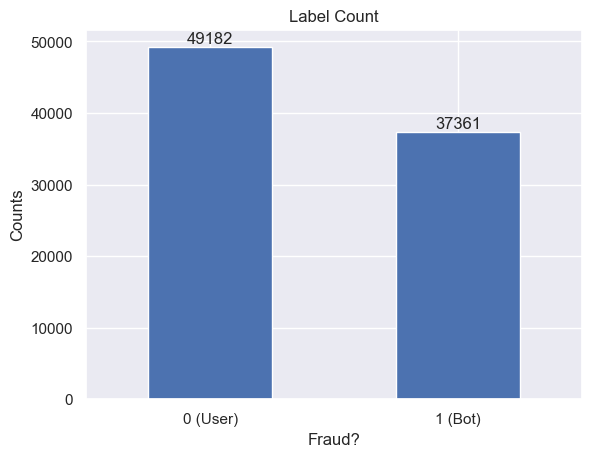

In [21]:
# dataset is almost balanced in contradiction to the initial raw dataset before being processed

ax = df.label.value_counts().plot(kind='bar')
ax.set_xticklabels(['0 (User)', '1 (Bot)'])

plt.title('Label Count')
plt.xlabel('Fraud?')
plt.ylabel('Counts')
plt.xticks(rotation=0)

# Annotate the bars with the count values
for i, value in enumerate(df.label.value_counts()):
    ax.text(i, value + 100, str(value), ha='center', va='bottom')

plt.show()

## Dataframe splitting

To avoid data snooping (and information leackage) so bias in the final results, we need to split the initial dataset into training (containig both training and validation sets, as will be explained and user later on) and testing datasets. From this point we can forget about testing data, and make all the data manipulations only on the testing part. The radom seed and splitting ratio are set to make the analysis repeatable in the future experiments.

In [22]:
# set initial random seed and proportion of test dataset

TEST_SIZE = 0.15
RANDOM_STATE = 42

df_train, df_test = train_test_split(df,
                                     test_size=TEST_SIZE,
                                     stratify=df["label"],
                                     random_state=RANDOM_STATE)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train, y_train = df_train.drop("label", axis=1), df_train["label"]
X_test, y_test = df_test.drop("label", axis=1), df_test["label"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73561, 20), (73561,), (12982, 20), (12982,))

In [23]:
df_train.tail(2)  # check if the data looks correctly

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
73559,10,0.80000,0.000000,0.5,0.60000,10,0.600000,0.900000,0.200000,0.800000,...,0.0,0.0,0.400000,0.0,0.4,1.0,0.2,0.0,0.0,1
73560,37,0.27027,0.027027,0.0,0.27027,29,0.513514,0.621622,0.405405,0.594595,...,0.0,0.0,0.297297,0.0,0.0,0.0,0.0,0.0,0.0,1


# Exploratory data analysis (EDA)

We take a look at dataset statistics as a whole and when considering only a particular class label. We see the features have different scale of values which can cause potential problems for non-tree-base ML models. Additionally, I have checked the diversity of values per class label and observe the fraud activities span greater range than non-fraud actions. Another way to gain some insights from the dataset is to observe the histograms. We can see some different bahaviour for distinct class labels. In general, the fraud actions produce more broader distribution of feature values.

## Class statistics

In [24]:
df_train.describe()

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,label
count,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,...,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000
mean,27.360096,0.361816,0.272521,0.166663,0.633302,10.064083,0.484420,0.653848,0.532534,0.315928,...,0.002794,0.128071,0.530441,0.022016,0.154968,0.267040,0.064717,0.008339,0.005863,0.431710
std,284.329253,0.347893,0.313156,0.304809,0.321127,95.116329,0.264810,0.296006,0.373168,0.329772,...,0.040909,0.215514,0.263542,0.138222,0.285403,0.441952,0.167669,0.089118,0.074009,0.495318
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000049,0.000530,0.000000,0.000000,...,0.000000,0.000000,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.400000,2.000000,0.285714,0.416667,0.200000,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.307692,0.166667,0.000000,0.666667,3.000000,0.500000,0.700000,0.500000,0.250000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.000000,0.666667,0.400000,0.222222,1.000000,7.000000,0.666667,0.941176,0.942857,0.533333,...,0.000000,0.200000,0.714286,0.000000,0.200000,1.000000,0.000000,0.000000,0.000000,1.000000
max,21016.000000,1.000000,1.000000,1.000000,1.000000,8321.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


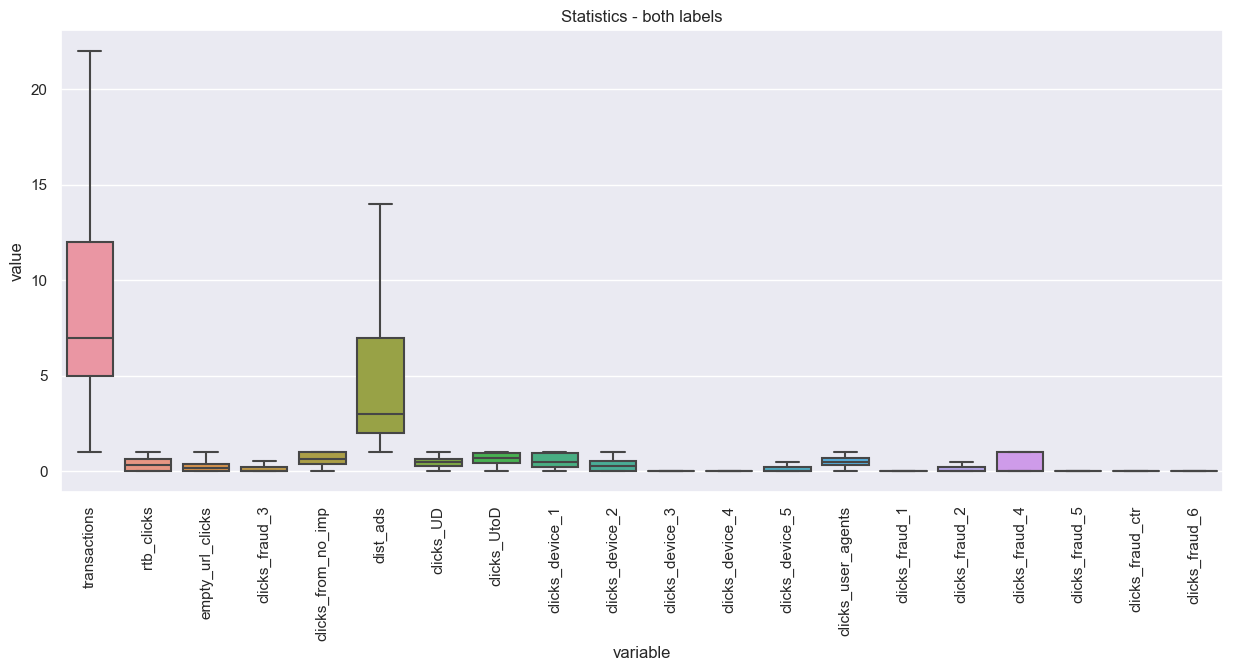

In [25]:
# statistics for both labels

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train), showfliers=False)

plt.title('Statistics - both labels')
plt.xticks(rotation=90)

plt.show()

In [26]:
X_train[y_train == 0].describe()

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,clicks_device_3,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6
count,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000,41804.000000
mean,13.712994,0.263012,0.325525,0.001314,0.668801,4.519041,0.508623,0.573979,0.669492,0.217760,0.013908,0.004917,0.093923,0.517204,0.009429,0.002006,0.000409,0.013453,0.012401,0.007176
std,160.448180,0.329127,0.334840,0.031185,0.333965,33.311128,0.261130,0.274209,0.372939,0.329461,0.101672,0.054170,0.225717,0.265957,0.088637,0.034695,0.018638,0.114400,0.110244,0.083978
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000049,0.000968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.428571,2.000000,0.333333,0.357143,0.400000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.125000,0.222222,0.000000,0.750000,3.000000,0.500000,0.600000,0.800000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,0.500000,0.500000,0.000000,1.000000,4.000000,0.666667,0.783385,1.000000,0.333333,0.000000,0.000000,0.000000,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20285.000000,1.000000,1.000000,1.000000,1.000000,3090.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


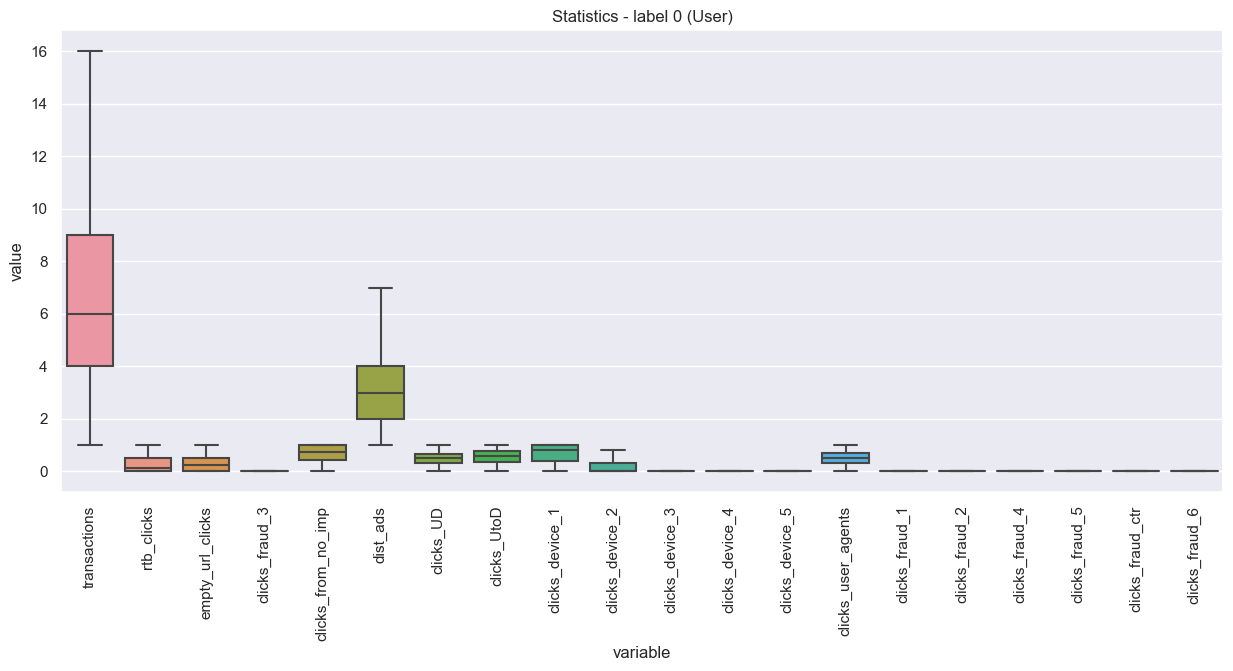

In [27]:
# statistics for label 0 (User)

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train[y_train == 0]), showfliers=False)

plt.title('Statistics - label 0 (User)')
plt.xticks(rotation=90)

plt.show()

In [28]:
X_train[y_train == 1].describe()

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,clicks_device_3,clicks_device_4,clicks_device_5,clicks_user_agents,clicks_fraud_1,clicks_fraud_2,clicks_fraud_4,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6
count,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.0,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000,31757.000000
mean,45.324747,0.491879,0.202748,0.384324,0.586572,17.363416,0.452559,0.758986,0.352246,0.445153,0.029579,0.0,0.173022,0.547866,0.038585,0.356324,0.618027,0.132198,0.002991,0.004136
std,390.908825,0.328618,0.266471,0.361338,0.297006,139.292492,0.266249,0.290744,0.286855,0.282202,0.155376,0.0,0.192266,0.259304,0.182840,0.340224,0.484981,0.199699,0.048453,0.058299
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000143,0.000530,0.000000,0.000000,0.000000,0.0,0.000000,0.000095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.181818,0.000000,0.000000,0.388889,3.000000,0.250000,0.600000,0.142857,0.250000,0.000000,0.0,0.000000,0.370370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.555556,0.117647,0.375000,0.600000,7.000000,0.416667,0.880000,0.300000,0.434783,0.000000,0.0,0.142857,0.500000,0.000000,0.363636,1.000000,0.000000,0.000000,0.000000
75%,16.000000,0.750000,0.250000,0.714286,0.818182,13.000000,0.625000,1.000000,0.500000,0.636364,0.000000,0.0,0.294118,0.750000,0.000000,0.666667,1.000000,0.250000,0.000000,0.000000
max,21016.000000,1.000000,1.000000,1.000000,1.000000,8321.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


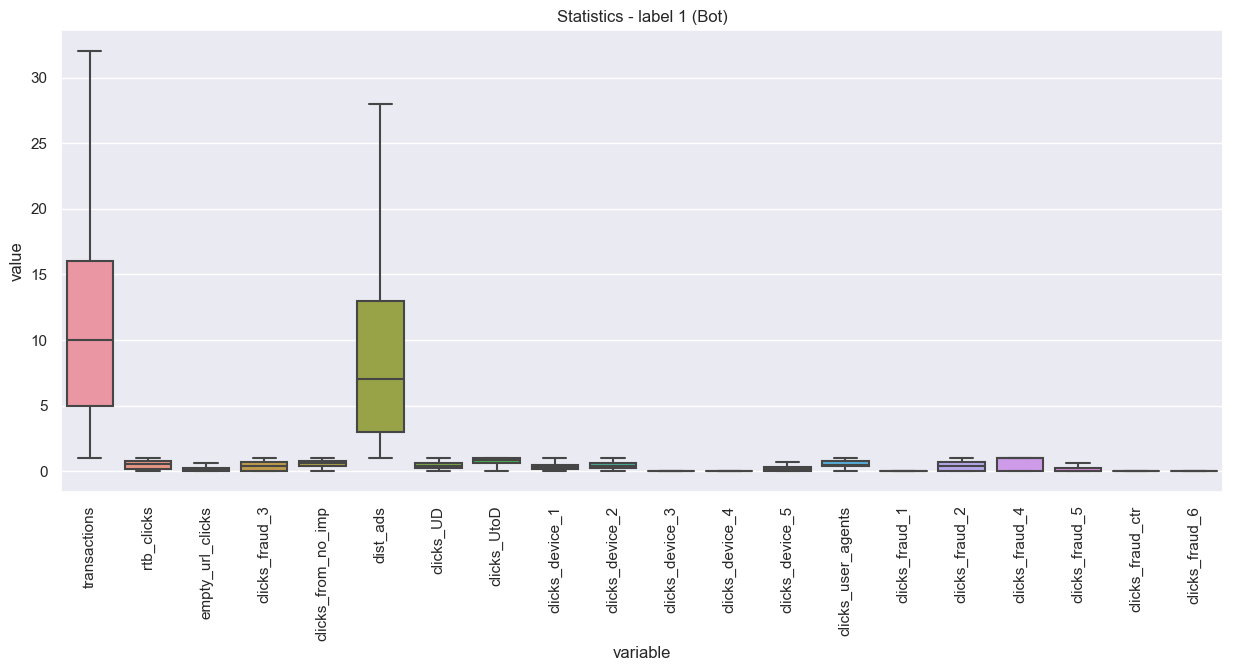

In [29]:
# statistics for label 1 (Bot)

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train[y_train == 1]), showfliers=False)

plt.title('Statistics - label 1 (Bot)')
plt.xticks(rotation=90)

plt.show()

## Features diversity

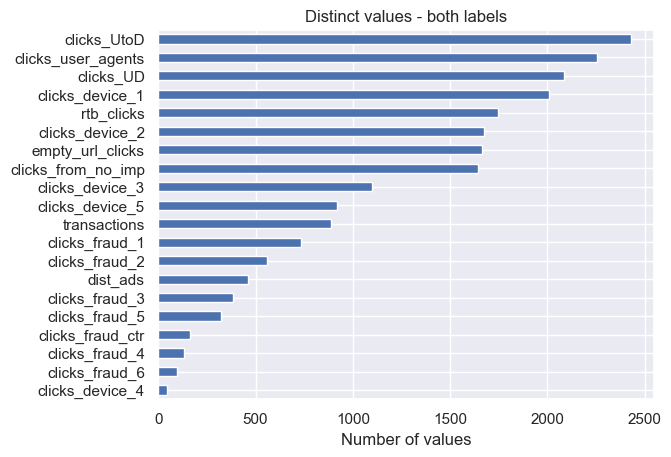

In [30]:
# diversity of different values of each feature for the entire dataset

counts = X_train.nunique()

counts.sort_values().plot(kind='barh')

plt.title('Distinct values - both labels')
plt.xlabel('Number of values')

plt.show()

In [31]:
# diversity of different values of each feature by class label

counts_0 = X_train[y_train == 0].nunique()
counts_1 = X_train[y_train == 1].nunique()

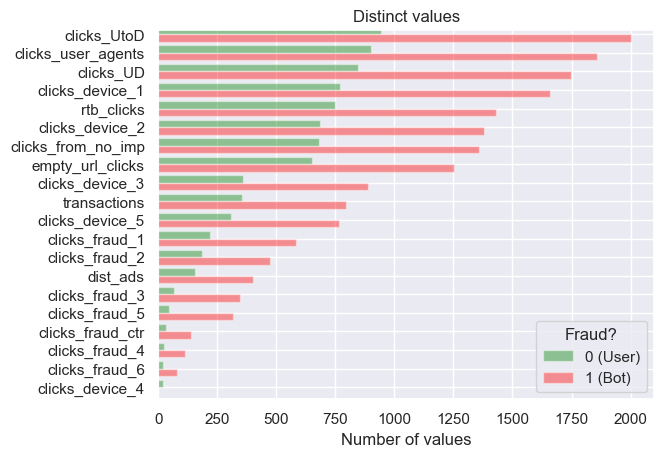

In [32]:
fig, ax = plt.subplots()

# Plot the first Series
counts_0.sort_values().plot(kind='barh', ax=ax, position=0, width=0.4, color='green', alpha=0.4, label='0 (User)')

# Plot the second Series
counts_1.sort_values().plot(kind='barh', ax=ax, position=1, width=0.4, color='red', alpha=0.4, label='1 (Bot)')

# Customize the plot
plt.title('Distinct values')
plt.xlabel('Number of values')
plt.legend(title='Fraud?')

plt.show()

## Distributions: histograms

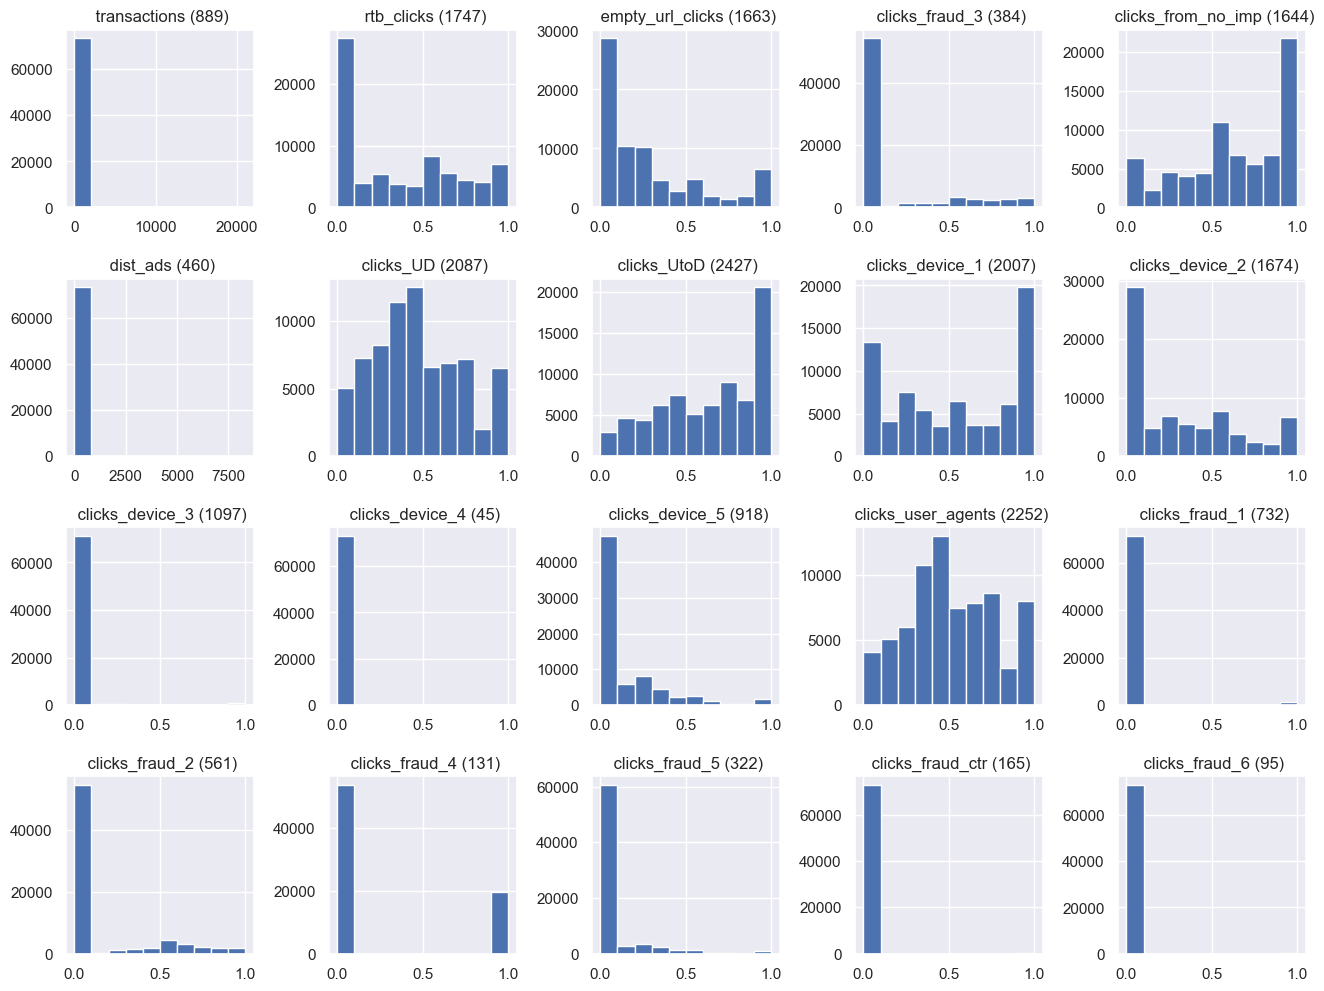

In [33]:
# histograms with different classes altogether (number of different values in the title)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 12))
ax = axes.ravel()

for i, column in enumerate(X_train):
    
    ax[i].hist(df_train[column])
    ax[i].set_title(f" {column} ({len(df_train[column].unique())})")

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

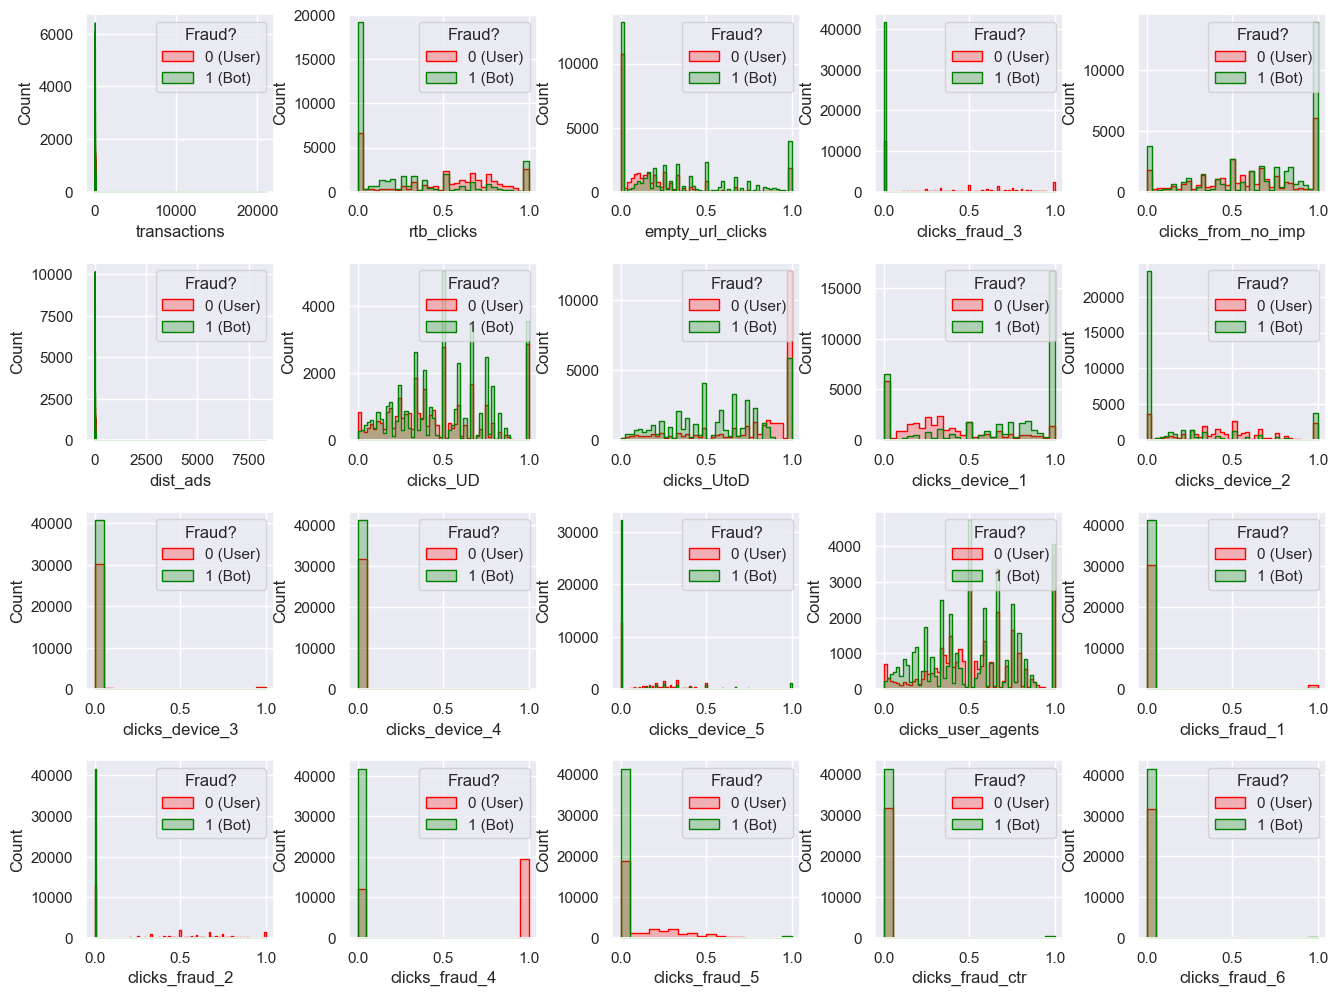

In [34]:
# histograms with different classes separated

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 12))
ax = axes.ravel()

for i, column in enumerate(X_train):
    
    sns.histplot(data=df_train, x=column, hue='label', element='step', palette={0: 'green', 1: 'red'}, ax=ax[i])
    ax[i].legend(title='Fraud?', labels=['0 (User)', '1 (Bot)'])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  

## Correlation

We can check which features correlate the most with the class label. The same way we can visualize the correlation coefficient between each pair of features, however the final plot is very messy thus uninformative. Note we plot an absolute value of correlation coefficients. Additionally, one can check the co-linearity of diffrent features using *VIF* (*variance inflation factor*) if needed and drop the corresponding feature. Another feature selection approaches are choosen.

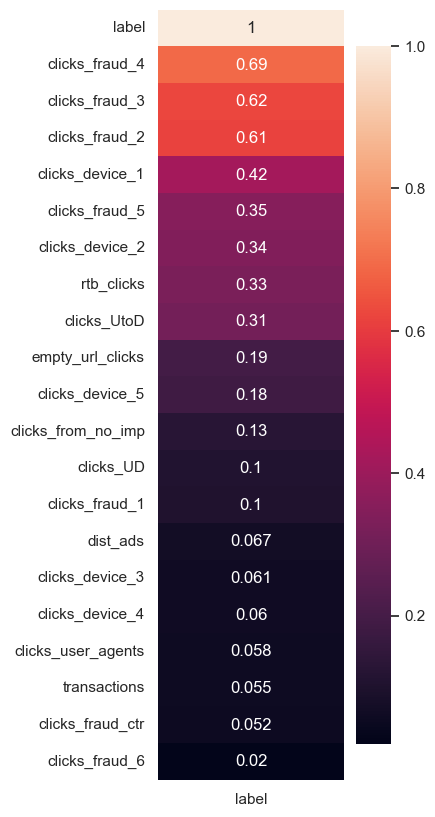

In [35]:
# correlation coefficients between features and class label

plt.figure(figsize=(3, 10))

df_corr = pd.DataFrame(np.abs(df_train.corr())['label'])
sns.heatmap(df_corr.sort_values(by="label", ascending=False), annot=True)
plt.show()

# Feature engineering

Besides the features provided in the collected dataset, we can increase the complexity of the initial dataset thus counts on better accuracy of the ML models, by creating additional features preferably on the basis of domain-knowledge. Another approach is to increase the dimensionality of the dataset. Also, because the presented histograms are non-gaussian as well as some features have different scales, we need to normalize the data to obtain better ML performance.

## Domain-knowledge features

Here the domain expert is irreplaceable as there is an infinite number of possible new features to be created. However, based on my own knowledge (intuition) confirmed by Internet search, I have constructed few possible features which may better reflects the frauds environment and are easily interpreteable. Later we can check if some of them gain our knowledge of the initial task. We can observe that the histograms for some of them differentiate both class labels well.

In [36]:
# names of new features to be included

new_columns = [
    'transactions_rtb_interaction',
    'empty_url_clicks_fraud_3_interaction',
    'transactions_per_dist_ads',
    'fraud_clicks_ratio',
    'clicks_device_consistency',
    'high_fraud_clicks',
    'suspicious_clicks_ratio'
]

In [37]:
df_train['transactions_rtb_interaction'] = df_train['transactions'] * df_train['rtb_clicks']
df_train['empty_url_clicks_fraud_3_interaction'] = df_train['empty_url_clicks'] * df_train['clicks_fraud_3']
df_train['transactions_per_dist_ads'] = df_train['transactions'] / (df_train['dist_ads'] + 1)
df_train['fraud_clicks_ratio'] = df_train[['clicks_fraud_1', 'clicks_fraud_2', 'clicks_fraud_3', 'clicks_fraud_4', 'clicks_fraud_5', 'clicks_fraud_6']].sum(axis=1) / df_train['transactions']
df_train['clicks_device_consistency'] = df_train[['clicks_device_1', 'clicks_device_2', 'clicks_device_3', 'clicks_device_4', 'clicks_device_5']].std(axis=1)
df_train['high_fraud_clicks'] = df_train[['clicks_fraud_1', 'clicks_fraud_2', 'clicks_fraud_3', 'clicks_fraud_4', 'clicks_fraud_5', 'clicks_fraud_6']].mean(axis=1)
df_train['suspicious_clicks_ratio'] = df_train['clicks_fraud_ctr'] / df_train['transactions']

df_train.sample(2)  # check if the feature addition works properly

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_fraud_ctr,clicks_fraud_6,label,transactions_rtb_interaction,empty_url_clicks_fraud_3_interaction,transactions_per_dist_ads,fraud_clicks_ratio,clicks_device_consistency,high_fraud_clicks,suspicious_clicks_ratio
34675,8,0.000000,0.75,0.0,1.000000,1,0.375000,0.500000,0.875,0.125,...,0.0,0.0,0,0.0,0.0,4.0,0.0,0.381199,0.0,0.0
52034,6,0.166667,0.00,0.0,0.833333,2,0.666667,0.666667,1.000,0.000,...,0.0,0.0,0,1.0,0.0,2.0,0.0,0.447214,0.0,0.0


In [38]:
df_train.describe()  # check the statistics of newly added features

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_fraud_ctr,clicks_fraud_6,label,transactions_rtb_interaction,empty_url_clicks_fraud_3_interaction,transactions_per_dist_ads,fraud_clicks_ratio,clicks_device_consistency,high_fraud_clicks,suspicious_clicks_ratio
count,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,...,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000,73561.000000
mean,27.360096,0.361816,0.272521,0.166663,0.633302,10.064083,0.484420,0.653848,0.532534,0.315928,...,0.008339,0.005863,0.431710,6.895800,0.019687,5.118113,0.105070,0.346344,0.113545,0.001519
std,284.329253,0.347893,0.313156,0.304809,0.321127,95.116329,0.264810,0.296006,0.373168,0.329772,...,0.089118,0.074009,0.495318,85.158320,0.050298,49.975052,0.224512,0.090690,0.179951,0.025783
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000049,0.000530,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.111803,0.000000,0.000000
25%,5.000000,0.000000,0.000000,0.000000,0.400000,2.000000,0.285714,0.416667,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.273861,0.000000,0.000000
50%,7.000000,0.307692,0.166667,0.000000,0.666667,3.000000,0.500000,0.700000,0.500000,0.250000,...,0.000000,0.000000,0.000000,2.000000,0.000000,1.200000,0.000000,0.346410,0.000000,0.000000
75%,12.000000,0.666667,0.400000,0.222222,1.000000,7.000000,0.666667,0.941176,0.942857,0.533333,...,0.000000,0.000000,1.000000,5.000000,0.000000,2.333333,0.140625,0.447214,0.266667,0.000000
max,21016.000000,1.000000,1.000000,1.000000,1.000000,8321.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,7925.999996,1.000000,5098.250000,4.000000,0.447214,0.666667,1.000000


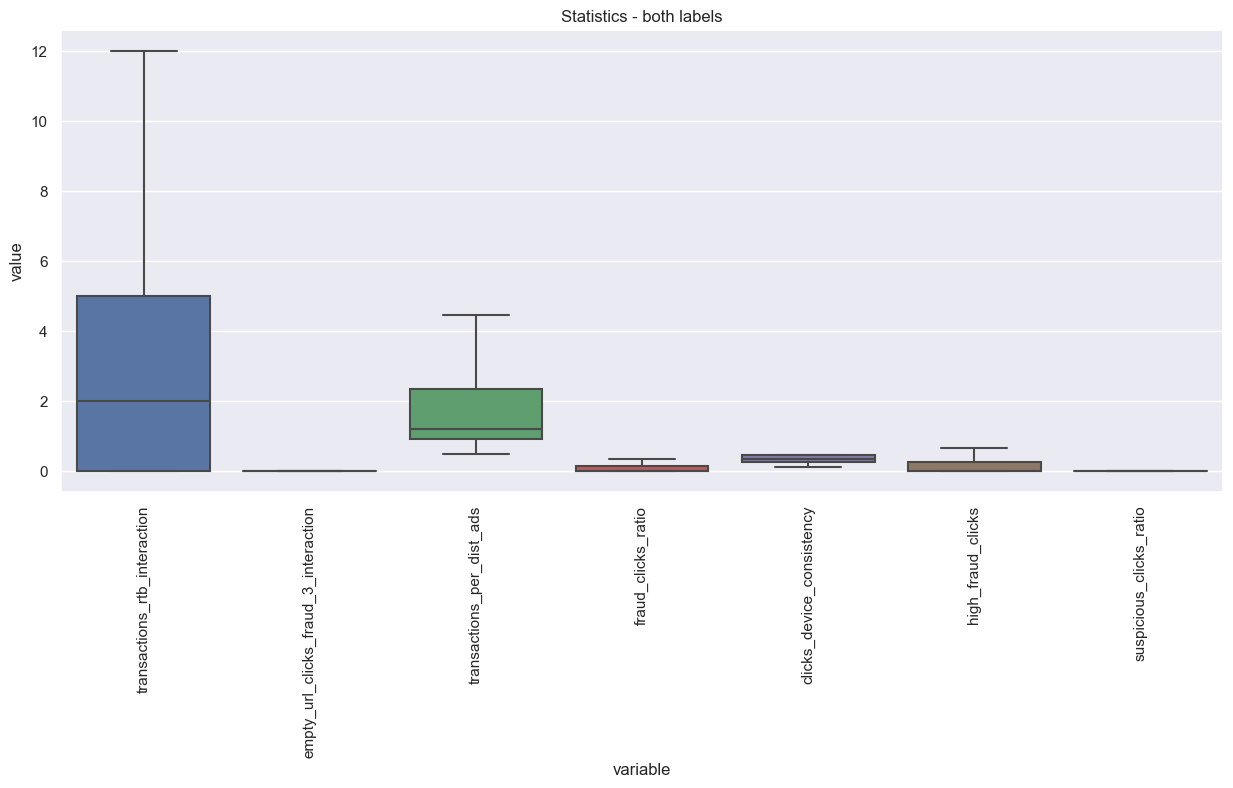

In [39]:
# statistics of newly added features (outliers are not present for clarity)

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(df_train[new_columns]), showfliers=False)

plt.title('Statistics - both labels')
plt.xticks(rotation=90)

plt.show()

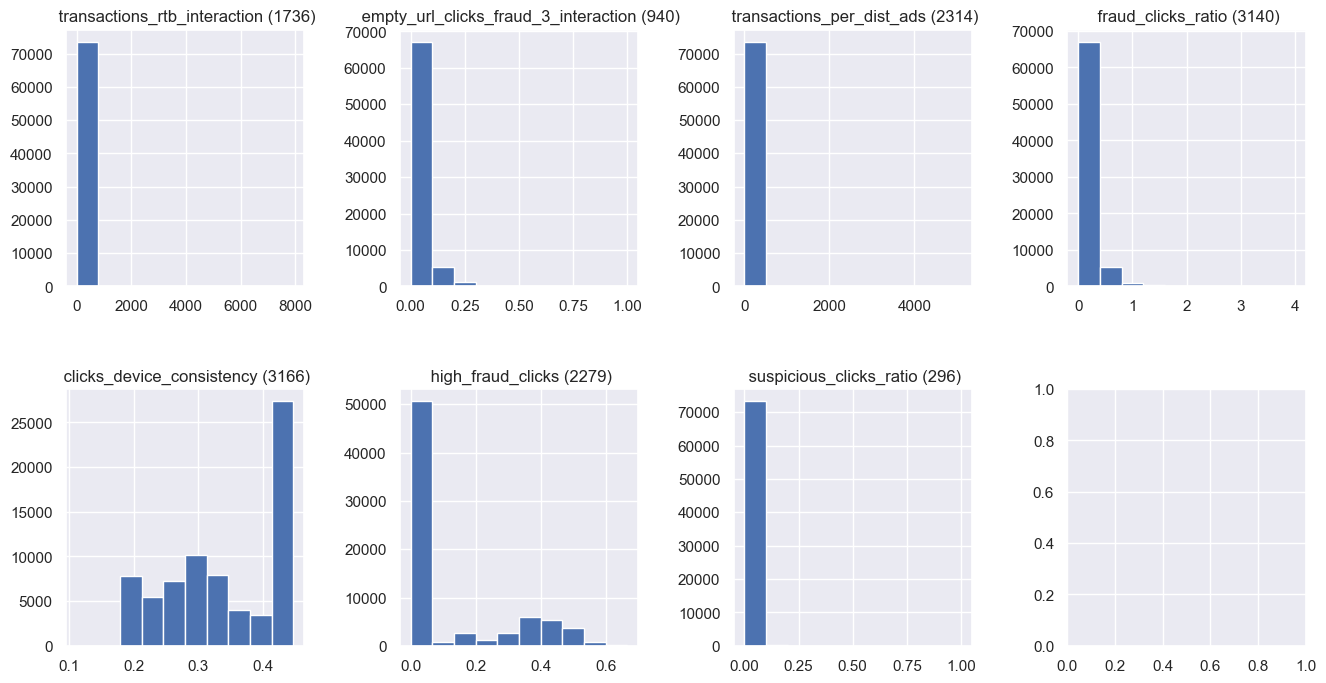

In [40]:
# histograms with different classes altogether (new features)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
ax = axes.ravel()

for i, column in enumerate(df_train[new_columns]):
    
    ax[i].hist(df_train[column])
    ax[i].set_title(f" {column} ({len(df_train[column].unique())})")

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

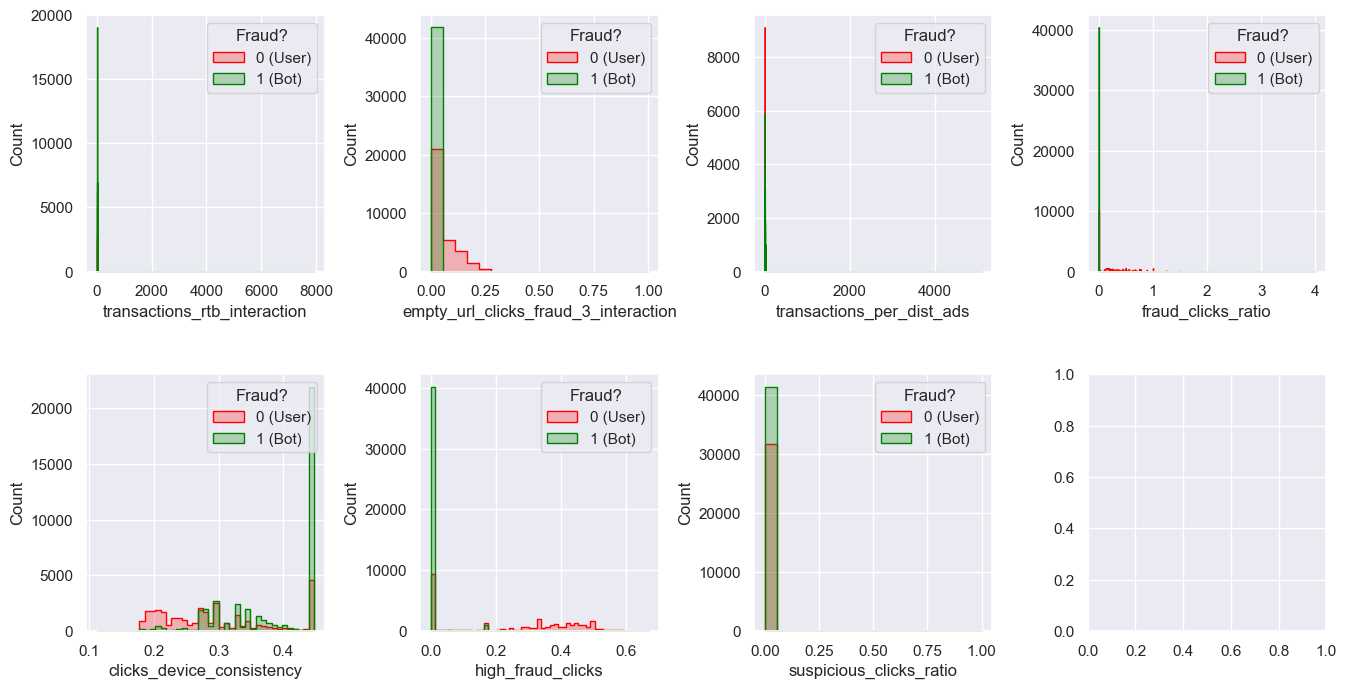

In [41]:
# histograms with different classes separated (new features)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
ax = axes.ravel()

for i, column in enumerate(df_train[new_columns]):
    
    sns.histplot(data=df_train, x=column, hue='label', element='step', palette={0: 'green', 1: 'red'}, ax=ax[i])
    ax[i].legend(title='Fraud?', labels=['0 (User)', '1 (Bot)'])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  

In [42]:
# new X_train and y_train dataframes formed based on the extended df (new features added)

X_train, y_train = df_train.drop("label", axis=1), df_train["label"]
X_train.shape, y_train.shape

((73561, 27), (73561,))

## Another approach: polynomial features

Another approach to increase the number of (potentially interesting) features is to use the polynomial features representing higher-order terms of basic features as well as interactions among them. Although not included in the following pipeline, here is one possible approach for creating them.

In [43]:
# Polynomial features

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)

poly_features = poly.get_feature_names_out(input_features=X_train.columns)
print(poly_features)

['transactions' 'rtb_clicks' 'empty_url_clicks' 'clicks_fraud_3'
 'clicks_from_no_imp' 'dist_ads' 'clicks_UD' 'clicks_UtoD'
 'clicks_device_1' 'clicks_device_2' 'clicks_device_3' 'clicks_device_4'
 'clicks_device_5' 'clicks_user_agents' 'clicks_fraud_1' 'clicks_fraud_2'
 'clicks_fraud_4' 'clicks_fraud_5' 'clicks_fraud_ctr' 'clicks_fraud_6'
 'transactions_rtb_interaction' 'empty_url_clicks_fraud_3_interaction'
 'transactions_per_dist_ads' 'fraud_clicks_ratio'
 'clicks_device_consistency' 'high_fraud_clicks' 'suspicious_clicks_ratio'
 'transactions^2' 'transactions rtb_clicks'
 'transactions empty_url_clicks' 'transactions clicks_fraud_3'
 'transactions clicks_from_no_imp' 'transactions dist_ads'
 'transactions clicks_UD' 'transactions clicks_UtoD'
 'transactions clicks_device_1' 'transactions clicks_device_2'
 'transactions clicks_device_3' 'transactions clicks_device_4'
 'transactions clicks_device_5' 'transactions clicks_user_agents'
 'transactions clicks_fraud_1' 'transactions clicks

In [44]:
# Combine with original data

df_poly = pd.DataFrame(X_poly, columns=poly_features)
df_poly['label'] = df_train['label']

df_poly.head()  # very large number of features, may create the noise during analysis

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,fraud_clicks_ratio clicks_device_consistency,fraud_clicks_ratio high_fraud_clicks,fraud_clicks_ratio suspicious_clicks_ratio,clicks_device_consistency^2,clicks_device_consistency high_fraud_clicks,clicks_device_consistency suspicious_clicks_ratio,high_fraud_clicks^2,high_fraud_clicks suspicious_clicks_ratio,suspicious_clicks_ratio^2,label
0,3.0,0.000000,0.666667,0.0,0.666667,2.0,0.666667,0.666667,1.000000,0.000000,...,0.0,0.0,0.0,0.200000,0.0,0.000000,0.0,0.0,0.000000,0
1,4.0,0.000000,0.000000,0.0,1.000000,2.0,0.500000,0.500000,0.000000,1.000000,...,0.0,0.0,0.0,0.200000,0.0,0.000000,0.0,0.0,0.000000,1
2,51.0,0.627451,0.000000,0.0,0.411765,34.0,0.176471,0.411765,0.627451,0.372549,...,0.0,0.0,0.0,0.083122,0.0,0.000000,0.0,0.0,0.000000,1
3,3.0,0.666667,0.666667,0.0,0.333333,2.0,0.666667,0.333333,0.000000,0.666667,...,0.0,0.0,0.0,0.088889,0.0,0.000000,0.0,0.0,0.000000,0
4,3.0,0.000000,0.000000,0.0,1.000000,2.0,0.666667,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.200000,0.0,0.149071,0.0,0.0,0.111111,0


## Power transform and scaling

As shown previously, the initial values of features are neither normalized nor have gaussian distribution of feature values. This two scaling are crucial for many ML algorithms. By implementing the power scaling (but another method like log-scaling can be used as well) and standarization (different scalers like min-max are possible) we see that the final histograms of feature values are at least a little more gaussian-like than before, as well as all data are centered around zero-mean value. It is worth checking if scaling or normalization does not decrease the performance of the model. Note the pipeline fitting is performed only on training dataset to avoid information leackage from the test data. Interesting point to check is whether the new features should be added based on the normalized initial features to obtain better distributions of final features.

In [45]:
# steps of the pipeline

feature_steps = [
    ('power_transformer', PowerTransformer()),
    ('scaler', StandardScaler()),
]

# pipeline definition
feature_pipeline = Pipeline(steps=feature_steps)

# pipeline training / fitting
feature_pipeline.fit(X_train)

Pipeline(steps=[('power_transformer', PowerTransformer()),
                ('scaler', StandardScaler())])

In [46]:
# implementing the pipeline on the training dataset

X_train = pd.DataFrame(feature_pipeline.transform(X_train), columns=X_train.columns).reset_index(drop=True)

df_train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
df_train.head(2)

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_fraud_ctr,clicks_fraud_6,transactions_rtb_interaction,empty_url_clicks_fraud_3_interaction,transactions_per_dist_ads,fraud_clicks_ratio,clicks_device_consistency,high_fraud_clicks,suspicious_clicks_ratio,label
0,-1.454173,-1.140628,1.331299,-0.593459,-0.003245,-0.646168,0.731984,-0.061509,1.238456,-1.108225,...,-0.099001,-0.082224,-1.186889,-0.466105,-0.605788,-0.647281,1.142268,-0.677704,-0.094633,0
1,-0.937984,-1.140628,-1.139992,-0.593459,1.231574,-0.646168,0.137729,-0.617979,-1.448996,1.611733,...,-0.099001,-0.082224,-1.186889,-0.466105,-0.035465,-0.647281,1.142268,-0.677704,-0.094633,1


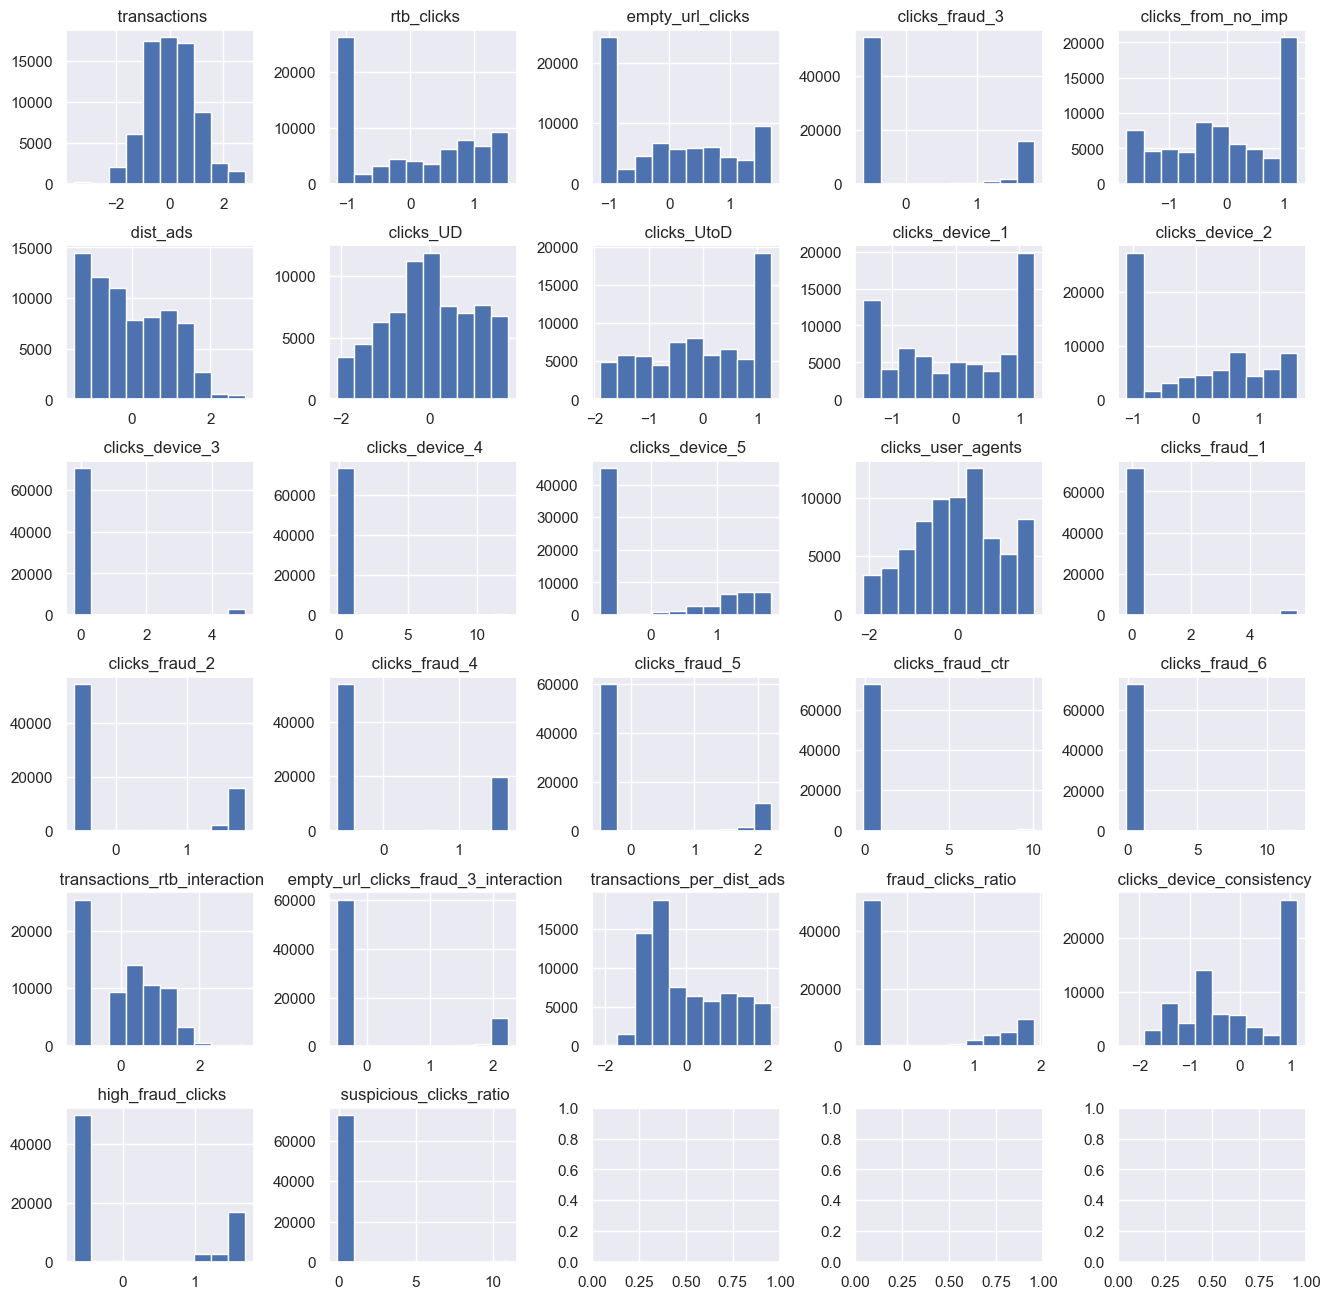

In [47]:
# histograms with different classes altogether (including newly added features)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 16))
ax = axes.ravel()

for i, column in enumerate(X_train):
    
    ax[i].hist(X_train[column])
    ax[i].set_title(f" {column}")

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

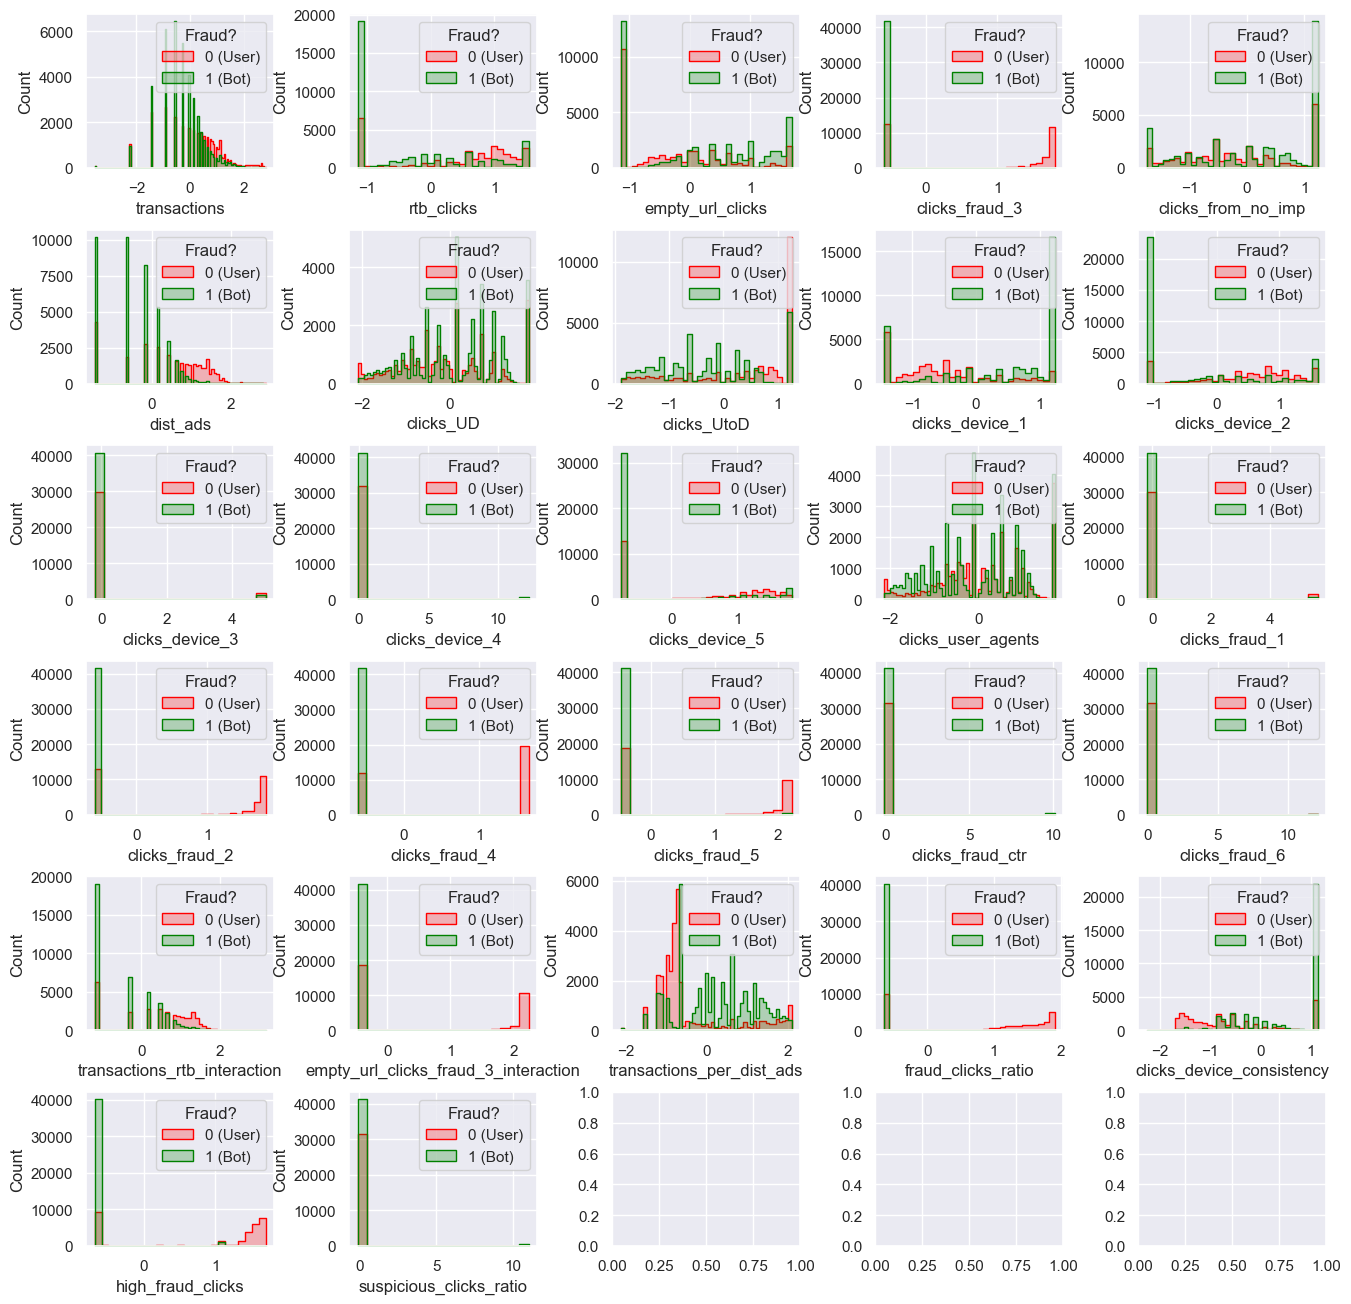

In [48]:
# histograms with different classes separated (including newly added features)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 16))
ax = axes.ravel()

for i, column in enumerate(X_train):
    
    sns.histplot(data=df_train, x=column, hue='label', element='step', palette={0: 'green', 1: 'red'}, ax=ax[i])
    ax[i].legend(title='Fraud?', labels=['0 (User)', '1 (Bot)'])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show() 

In [49]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

df_train.describe()  # check the statistics of the dafaset after normalization

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_fraud_ctr,clicks_fraud_6,transactions_rtb_interaction,empty_url_clicks_fraud_3_interaction,transactions_per_dist_ads,fraud_clicks_ratio,clicks_device_consistency,high_fraud_clicks,suspicious_clicks_ratio,label
count,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,...,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000,73561.000
mean,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.432
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.495
min,-3.551,-1.141,-1.140,-0.593,-1.742,-1.452,-2.085,-1.890,-1.449,-1.108,...,-0.099,-0.082,-1.187,-0.466,-2.110,-0.647,-2.256,-0.678,-0.095,0.000
25%,-0.563,-1.141,-1.140,-0.593,-0.814,-0.646,-0.719,-0.871,-0.883,-1.108,...,-0.099,-0.082,-1.187,-0.466,-0.806,-0.647,-0.832,-0.678,-0.095,0.000
50%,-0.044,0.056,-0.044,-0.593,-0.003,-0.166,0.138,0.058,-0.065,0.074,...,-0.099,-0.082,0.187,-0.466,-0.237,-0.647,-0.066,-0.678,-0.095,0.000
75%,0.658,0.956,0.809,1.212,1.232,0.745,0.732,1.004,1.093,0.870,...,-0.099,-0.082,0.835,-0.466,0.864,1.134,1.142,1.386,-0.095,1.000
max,2.815,1.535,1.681,1.807,1.232,2.885,1.777,1.257,1.238,1.612,...,10.104,12.163,3.170,2.240,2.094,1.907,1.142,1.698,11.011,1.000


In [50]:
pd.reset_option('display.float_format')

## Conclusions

Below we can compare the statistics of the transformed dataset for both class labels as well as individual label value. The outliers are not included on the plot for better clarity. The distribution of features are zero-centered and we can observe that some of them have variance greater than the others thus are potential good candidates for predicting the class labels. In the same manner, the features with very low variance can be manually excluded from further analysis. Also, by comparing distributions for distinct class labels, one can observe the variability of some features depends strongly on the class label. Moreover, the correlation coefficients of some new features are aven greater than for initial features. It will be interesting to see how adding categorical variables (yes/no, greater than, etc.) change the final ML model performance. The process of feature engineering may include the outliers drop (e.g., based of *z-score* or *IQR* values) however I have decided to ommit this step as in the case of rare events as fraud detection, the outliers are important part of the minority class.

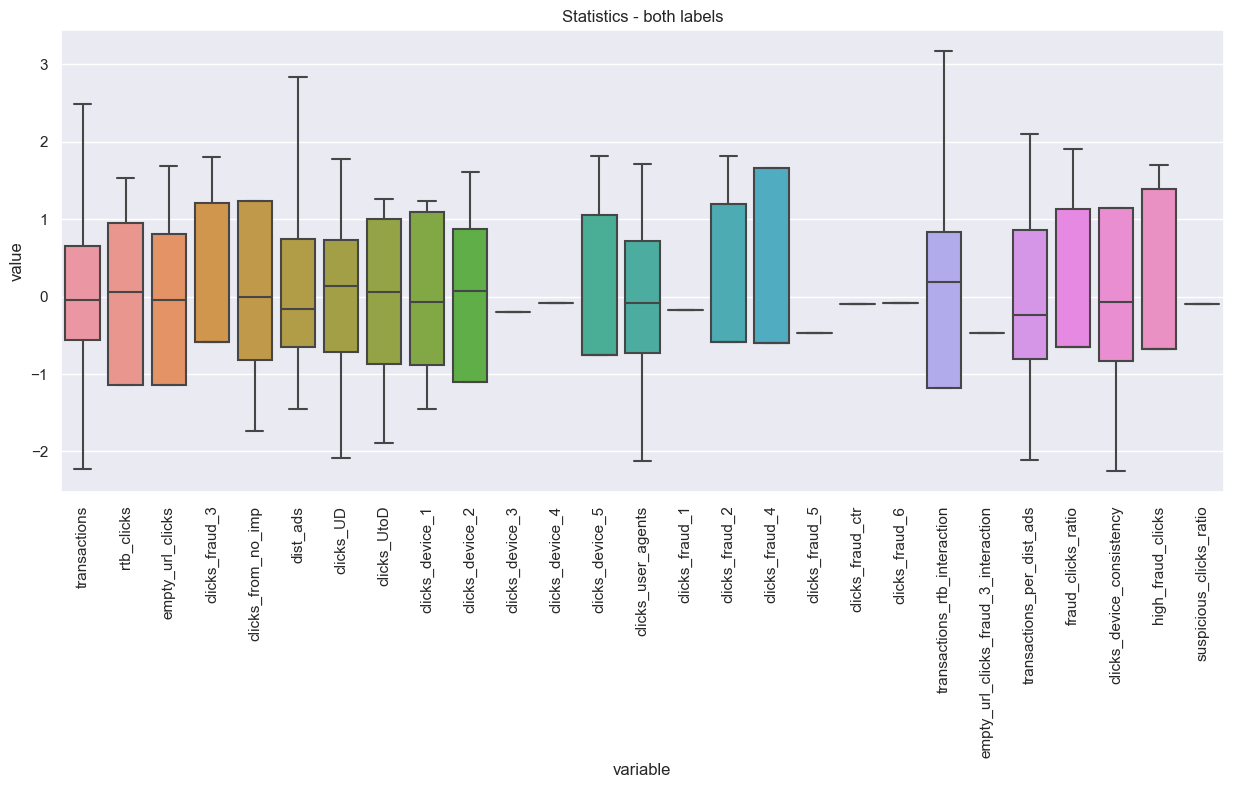

In [51]:
# statistics for both class labels

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train), showfliers=False)

plt.title('Statistics - both labels')
plt.xticks(rotation=90)

plt.show()

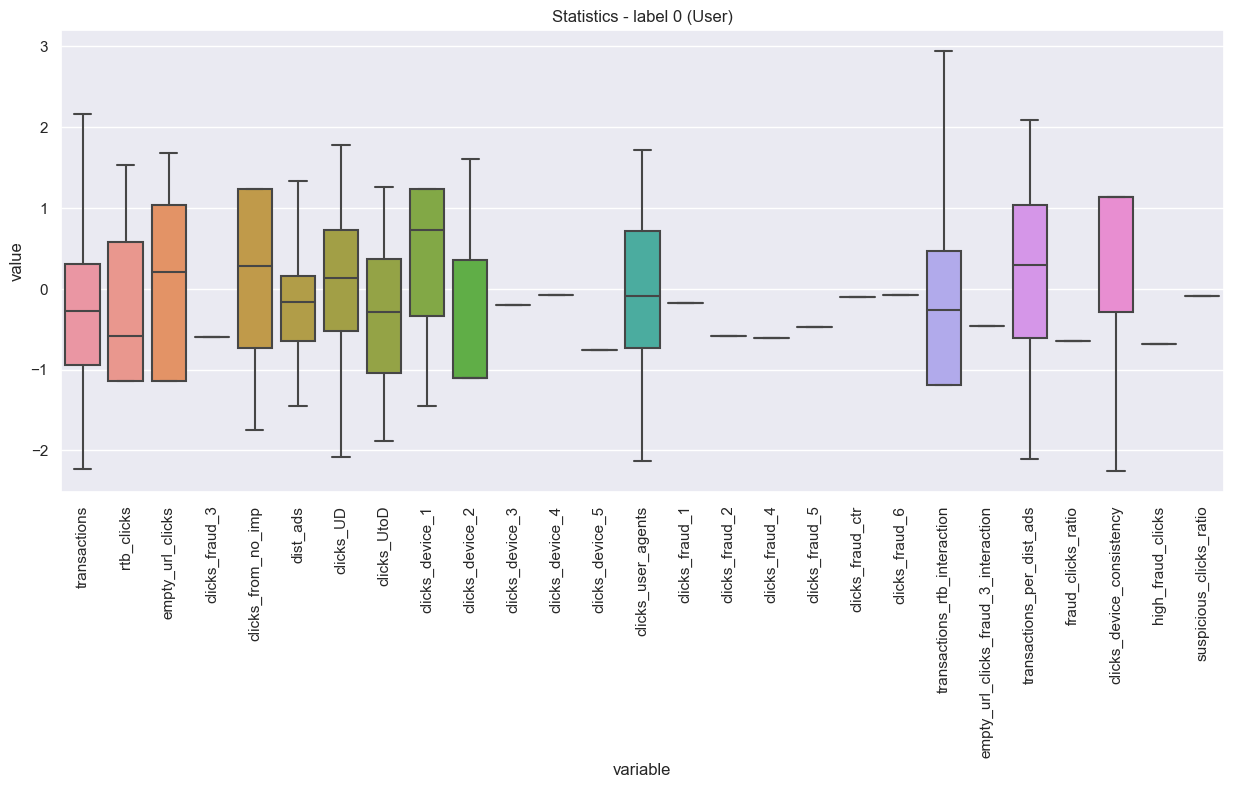

In [52]:
# statistics for label 0 (User)

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train[y_train == 0]), showfliers=False)

plt.title('Statistics - label 0 (User)')
plt.xticks(rotation=90)

plt.show()

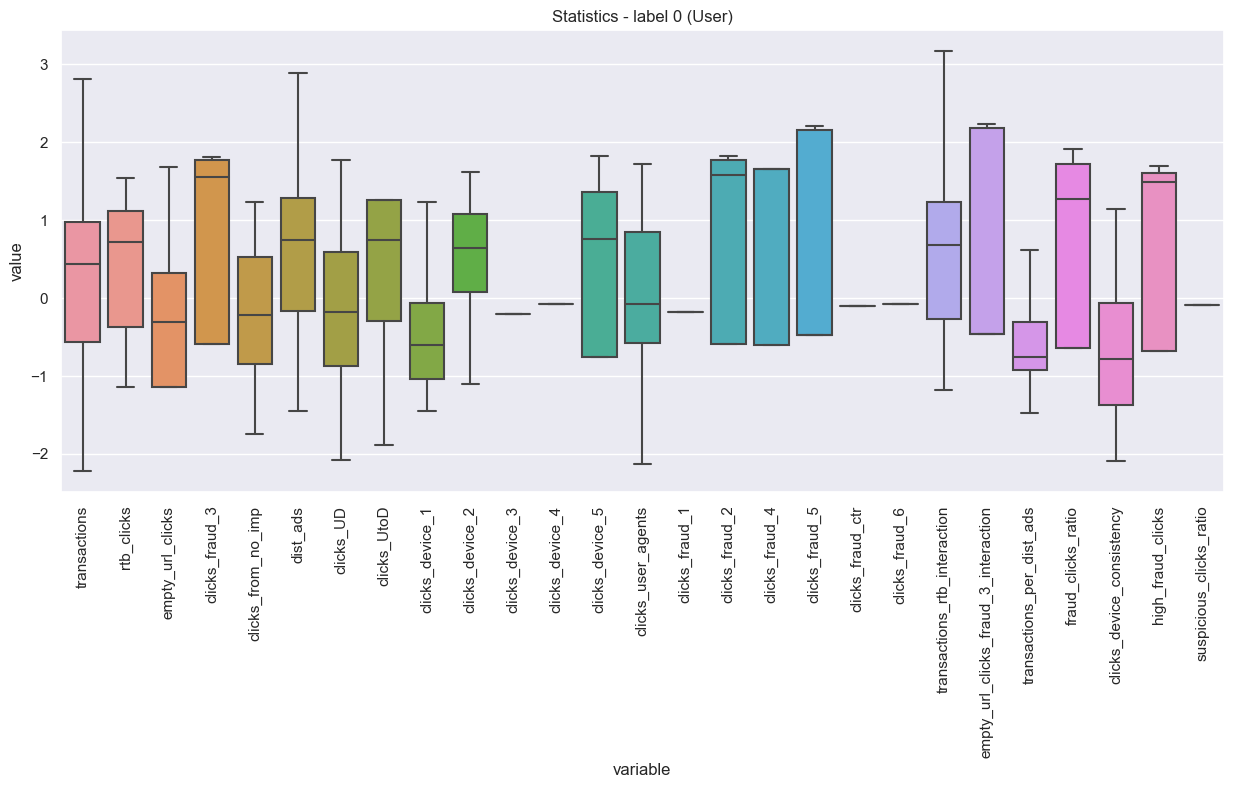

In [53]:
# statistics for label 1 (Bot)

plt.figure(figsize=(15, 6))

sns.boxplot(x="variable", y="value", data=pd.melt(X_train[y_train == 1]), showfliers=False)

plt.title('Statistics - label 0 (User)')
plt.xticks(rotation=90)

plt.show()

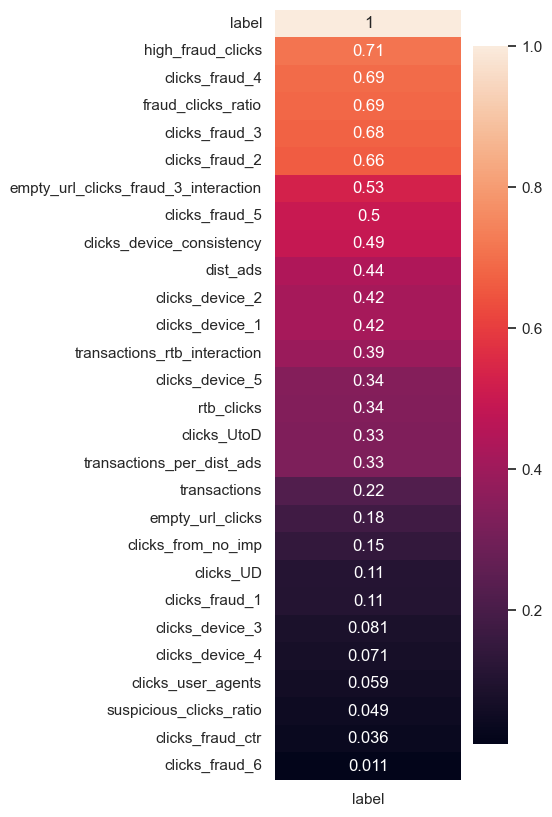

In [54]:
# correlation coefficients including newly added features

plt.figure(figsize=(3, 10))

df_corr = pd.DataFrame(np.abs(df_train.corr())['label'])
sns.heatmap(df_corr.sort_values(by="label", ascending=False), annot=True)
plt.show()

# Machine learning models

## Feature engineering pipeline

To automate the feature engineering pipeline in case of the testing dataset, I construct the pipeline which includes the custom-made transformer. The whole filtered dataset is loaded again, the train-test split is performed, and then the feature engineering procedures made in the previous steps of the analysis are performed. The pipelnie is trained only on training data to avoid information leackage from the testing dataset. Next the pretrained model is used to transform the testing dataset. Additional steps of the pipeline, as drop duplicated, fill the missing values, generate polynomial features, perform dimensionality reduction (e.g., `PCA`) can be implemented in this pipeline with ease using pre-defined `scikit-learn` transformers but at the cost of interpretability of the results.

In [55]:
class AddColumnsTransformer(BaseEstimator, TransformerMixin):
    """Custom transformer adding domain-knowledge features to the dataset."""
    
    def __init__(self, columns_to_add: list):
        self.columns_to_add = columns_to_add
    
    # even if nothing to fit, this method must return self
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X['transactions_rtb_interaction'] = X['transactions'] * X['rtb_clicks']
        X['empty_url_clicks_fraud_3_interaction'] = X['empty_url_clicks'] * X['clicks_fraud_3']
        X['transactions_per_dist_ads'] = X['transactions'] / (X['dist_ads'] + 1)
        X['fraud_clicks_ratio'] = X[['clicks_fraud_1', 'clicks_fraud_2', 'clicks_fraud_3', 'clicks_fraud_4', 'clicks_fraud_5', 'clicks_fraud_6']].sum(axis=1) / X['transactions']
        X['clicks_device_consistency'] = X[['clicks_device_1', 'clicks_device_2', 'clicks_device_3', 'clicks_device_4', 'clicks_device_5']].std(axis=1)
        X['high_fraud_clicks'] = X[['clicks_fraud_1', 'clicks_fraud_2', 'clicks_fraud_3', 'clicks_fraud_4', 'clicks_fraud_5', 'clicks_fraud_6']].mean(axis=1)
        X['suspicious_clicks_ratio'] = X['clicks_fraud_ctr'] / X['transactions']
        
        return X

In [56]:
# again the dataset is loaded and splitted into training and testing datasets

df = pd.read_csv(filtered_df_path)

TEST_SIZE = 0.15
RANDOM_STATE = 42

df_train, df_test = train_test_split(df,
                                     test_size=TEST_SIZE,
                                     stratify=df["label"],
                                     random_state=RANDOM_STATE)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train, y_train = df_train.drop("label", axis=1), df_train["label"]
X_test, y_test = df_test.drop("label", axis=1), df_test["label"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73561, 20), (73561,), (12982, 20), (12982,))

In [57]:
# list of domain-knowledge features served as an input to the pipeline

new_columns = [
    'transactions_rtb_interaction',
    'empty_url_clicks_fraud_3_interaction',
    'transactions_per_dist_ads',
    'fraud_clicks_ratio',
    'clicks_device_consistency',
    'high_fraud_clicks',
    'suspicious_clicks_ratio'
]

feature_steps = [
    ('features_adder', AddColumnsTransformer(columns_to_add=new_columns)),
    ('power_transformer', PowerTransformer()),
    ('scaler', StandardScaler()),
]

feature_pipeline = Pipeline(steps=feature_steps)

# pipeline fitting only on training dataset
feature_pipeline.fit(X_train)

Pipeline(steps=[('features_adder',
                 AddColumnsTransformer(columns_to_add=['transactions_rtb_interaction',
                                                       'empty_url_clicks_fraud_3_interaction',
                                                       'transactions_per_dist_ads',
                                                       'fraud_clicks_ratio',
                                                       'clicks_device_consistency',
                                                       'high_fraud_clicks',
                                                       'suspicious_clicks_ratio'])),
                ('power_transformer', PowerTransformer()),
                ('scaler', StandardScaler())])

In [58]:
# previously trained pipeline transforms both training and testing datasets

X_train = pd.DataFrame(feature_pipeline.transform(X_train), columns=X_train.columns).reset_index(drop=True)
X_test = pd.DataFrame(feature_pipeline.transform(X_test), columns=X_test.columns).reset_index(drop=True)

X_test  # check if the test set is correctly processed by the pipeline

,transactions,rtb_clicks,empty_url_clicks,clicks_fraud_3,clicks_from_no_imp,dist_ads,clicks_UD,clicks_UtoD,clicks_device_1,clicks_device_2,...,clicks_fraud_5,clicks_fraud_ctr,clicks_fraud_6,transactions_rtb_interaction,empty_url_clicks_fraud_3_interaction,transactions_per_dist_ads,fraud_clicks_ratio,clicks_device_consistency,high_fraud_clicks,suspicious_clicks_ratio
0,-3.551241,-1.140628,1.681284,-0.593459,1.231574,-1.451560,1.776879,1.256573,1.238456,-1.108225,...,2.212989,-0.099001,-0.082224,-1.186889,-0.466105,-2.110002,1.906636,1.142268,1.505181,-0.094633
1,-0.274362,1.535435,1.331299,-0.593459,-1.742233,0.593033,0.137729,-0.061509,1.238456,-1.108225,...,-0.474466,-0.099001,-0.082224,0.960065,-0.466105,-0.932045,-0.647281,1.142268,-0.677704,-0.094633
2,-0.274362,-1.140628,-1.139992,-0.593459,-0.003245,0.593033,0.731984,-1.107490,0.376947,0.351145,...,-0.474466,-0.099001,-0.082224,-1.186889,-0.466105,-0.932045,-0.647281,-0.585280,-0.677704,-0.094633
3,0.748619,-1.140628,-0.560557,-0.593459,1.231574,-0.646168,-0.007714,-0.495547,1.238456,-1.108225,...,-0.474466,-0.099001,-0.082224,-1.186889,-0.466105,1.497529,-0.647281,1.142268,-0.677704,-0.094633
4,2.005438,-1.140628,1.681284,-0.593459,1.231574,2.108384,-2.007106,-1.643546,0.785813,-1.108225,...,-0.474466,-0.099001,-0.082224,-1.186889,-0.466105,-0.179258,-0.587868,0.050923,-0.168537,-0.094633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12977,-1.454173,1.535435,1.681284,-0.593459,-1.742233,-0.165694,-0.518416,1.256573,-0.515689,-1.108225,...,-0.474466,-0.099001,-0.082224,0.473366,-0.466105,-1.221917,1.719427,-0.585280,1.050842,-0.094633
12978,2.518076,-0.979468,1.443626,-0.593459,1.050081,1.478915,-1.747737,-1.805481,0.797809,-0.254063,...,-0.474466,-0.099001,-0.082224,1.405597,-0.466105,2.020166,-0.647281,0.067454,-0.677704,-0.094633
12979,-1.454173,-1.140628,-1.139992,-0.593459,-0.003245,-0.165694,0.731984,-0.061509,1.238456,-1.108225,...,-0.474466,-0.099001,-0.082224,-1.186889,-0.466105,-1.221917,-0.647281,1.142268,-0.677704,-0.094633
12980,-0.562566,1.535435,-1.139992,-0.593459,-1.742233,0.404662,0.500914,0.432612,-1.448996,1.611733,...,-0.474466,-0.099001,-0.082224,0.834622,-0.466105,-0.992755,-0.647281,1.142268,-0.677704,-0.094633


## Models performance

In order to choose the optimal ML model to solve the problem, I have decided to check different ML approaches listed below. For each model metrics such as *accuracy*, *precision*, *recall* and *F1-score* are calculated, as well as computation speed is checked. For correct comparison between different models on the same data, we splitting the previous training dataset into new training and validation datasets (only for checking different models). Instead, the same initial *k-fold cross validation* split can be used to perform models without separate validation dataset (to produce the mean and variance of the predictions).

In [59]:
def calculate_metrics(y_test, y_pred):

    metrics = {
        'accuracy': round(accuracy_score(y_test, y_pred), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'F1-score': round(f1_score(y_test, y_pred), 3)
    }
    
    return metrics
    
def train_predict_and_evaluate(model, X_train, X_test, y_train, y_test):
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return calculate_metrics(y_test, y_pred)

In [60]:
# train-validation split (random seed as split ration set as before)

TEST_SIZE = 0.15
RANDOM_STATE = 42

X_train_0, X_valid, y_train_0, y_valid = train_test_split(X_train,
                                                          y_train,
                                                          test_size=TEST_SIZE,
                                                          stratify=y_train,
                                                          random_state=RANDOM_STATE)

X_train_0.shape, y_train_0.shape, X_valid.shape, y_valid.shape

((62526, 27), (62526,), (11035, 27), (11035,))

### List of models to be tested

In [61]:
# linear model with added regularization (parameters set randomly)
param = {'C': 0.1, 'penalty': 'l2'}
model1 = LogisticRegression(**param)

# Support Vector Machine classifier with Gaussian kernel
param = {'C': 1.0, 'kernel': 'rbf'}
model2 = SVC(**param)

# example of decission tree classifier (parameters set randomly)
param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 10}
model3 = DecisionTreeClassifier(**param)

# aggregating random forest use all the features but different subset among the individual trees
model4 = RandomForestClassifier()

# iterative boosting algorithm optimizing the weights of the wrongly classified samples
param = {'learning_rate': 0.05, 'n_estimators': 100}
model5 = AdaBoostClassifier(**param)

# iterative boosting algorithm optimizing the gradient of a cost function
param = {'learning_rate': 0.01, 'n_estimators': 100}
model6 = GradientBoostingClassifier(**param)

# Gaussian Naive-Bayes assuming independent features of numerical values
model7 = GaussianNB()

# simple two-layers perceptron as an example of neural network model
param = {'hidden_layer_sizes': (30, 30), 'max_iter': 20, 'alpha': 1e-3, 'solver': 'adam',
         'random_state': RANDOM_STATE, 'verbose': False, 'tol': 1e-3}
model8 = MLPClassifier(**param)

In [62]:
# testing the speed and accuracy of different ML models

models = [('LR', model1), ('SVC', model2), ('DT', model3), ('RF', model4),
          ('Ada', model5), ('GB', model6), ('GNB', model7),  ('MLP', model8)]

results_list = []

for model_name, model in models:
    
    print(f"Processing model: {model_name}")
    
    start_time = datetime.now()
    metrics = train_predict_and_evaluate(model, X_train_0, X_valid, y_train_0, y_valid)
    execution_time = (datetime.now() - start_time).total_seconds()
    
    metrics['model'] = model_name
    metrics['time'] = round(execution_time, 3)
    results_list.append(metrics)
    
    print(f"Finished in: {round(execution_time, 3)} sec\n")

Processing model: LR
Finished in: 0.386 sec

Processing model: SVC
Finished in: 90.015 sec

Processing model: DT
Finished in: 0.051 sec

Processing model: RF
Finished in: 8.373 sec

Processing model: Ada
Finished in: 6.927 sec

Processing model: GB
Finished in: 11.432 sec

Processing model: GNB
Finished in: 0.06 sec

Processing model: MLP
Finished in: 3.457 sec



In [63]:
# different metrics for a validation dataset

results = pd.DataFrame(results_list)
results.set_index('model', inplace=True)

results

,accuracy,precision,recall,F1-score,time
model,,,,,
LR,0.891,0.934,0.805,0.865,0.386
SVC,0.923,0.959,0.859,0.906,90.015
DT,0.856,0.967,0.691,0.806,0.051
RF,0.927,0.944,0.883,0.912,8.373
Ada,0.853,0.959,0.690,0.803,6.927
GB,0.882,0.935,0.780,0.851,11.432
GNB,0.861,0.940,0.725,0.819,0.060
MLP,0.925,0.947,0.876,0.910,3.457


## Conclusions

The fastest algorithms are `LogisticRegression`, `DecissionTreeClasifier` and `Gaussian Naive-Bayes`. As expected, the neural network (`MLP`) and different types of either bagging or boosting methods (`RF`, `ADa`, `GB`) are much slower. In case of frauds detection in real time the speed is crucial thus I decided to optimize the `LR` and `DT` algorithm from now on. In case of `GNB` the fundamental assumptions are not valid as I have constructed new features which are not independent of others. However, even if not theoreticaly-correct, it has a `partial_fit()` method allowing for *on-line* learning on new batches of samples, in real-time.  The slowest is `SupportVectorMachine` as dual-problem calculation can be hard for such a noisy data as some soft margins need to be created. Also, I have tried with `kNN` model but it cannot work with this particular dataset with the default initialization. Please note that none of the algorithm is better in all metrics than the others. Chosen models are also the best then interpretability matters which can matter for the business.

# LogisticRegression

The first chosen model is `LogisticRegression` which is very fast and easy to interpret. This time I have decided to optimize for *F1-score* to provide the balance between *precision* and *recall* metrics. In this scenario the model should minimize the number of *false positive* and *false negative* events at the same time obtaining the balance between them. In other words all fraud events should be detected but not at the cost of classifying all suspicious event as fraud which may be harmful for normal users. Best parameters of the model are found using `GridSearch` wich *cross-validation*.

## GridSearch

In [64]:
# pameters supported by the model

model_LR = LogisticRegression()
model_LR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [65]:
# parameters grid used for GridSearch with cross-validation

param_grid = {
    "C": [0, 0.5, 0.3, 0.1, 0.05, 0.01],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["saga"]
}

gs = GridSearchCV(model_LR, param_grid, cv=5, scoring='f1')
gs = gs.fit(X_train, y_train)

In [66]:
# here we optimie for 'F1-score'

print(f"Best params: {gs.best_params_}")
print(f"Best score: {round(gs.best_score_, 3)}")

Best params: {'C': 0.5, 'penalty': None, 'solver': 'saga'}
Best score: 0.871


## Best model

In [67]:
# retraining the best found model on the entire training dataset

best_model = LogisticRegression(**gs.best_params_)
best_model.fit(X_train, y_train)

print(f"Best score: {round(gs.best_score_, 3)}")

Best score: 0.871


In [68]:
best_model.coef_

array([[ 2.25625486, -0.56531077, -0.28727515,  0.7969645 , -0.12746584,
        -1.05701003, -0.27361429, -0.12142811,  0.26526336,  0.69054602,
         0.30852642, -0.69383631, -0.24509668,  0.61350031,  0.16898291,
        -0.13699097,  2.52363458, -0.65779873,  0.09777706, -0.15187063,
         0.32869571,  0.3568444 , -1.51959787,  1.86282573, -0.4269304 ,
        -0.57853997, -0.33071244]])

In [69]:
# importance of different model features (note the absolute values)

importance = pd.DataFrame(
    {"feature": X_train.columns, "coef": best_model.coef_.flatten(), "coef_abs": np.abs(best_model.coef_.flatten())}
).sort_values("coef_abs", ascending=False).reset_index(drop=True)

importance

,feature,coef,coef_abs
0,clicks_fraud_4,2.523635,2.523635
1,transactions,2.256255,2.256255
2,fraud_clicks_ratio,1.862826,1.862826
3,transactions_per_dist_ads,-1.519598,1.519598
4,dist_ads,-1.057010,1.057010
5,clicks_fraud_3,0.796964,0.796964
6,clicks_device_4,-0.693836,0.693836
7,clicks_device_2,0.690546,0.690546
8,clicks_fraud_5,-0.657799,0.657799
9,clicks_user_agents,0.613500,0.613500


## Performance metrics

We compute the confussion matrices as well as classification reports for both training and testing datasets. In both cases the results are comparable thus no overfitting occurs. All the metrics are around 90% but in case of imbalanced dataset the *accuracy* is not a good indicator (note here we maximize for *F1-score*). Both *F1-score* and *recall* are greater for negative (non-fraudulent) class as it is probably more homogenous in feature values span as mentioned earlier.

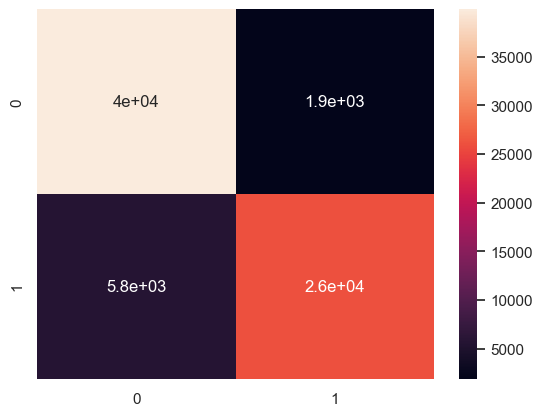

In [70]:
# metrics on the training dataset

preds = best_model.predict(X_train)

sns.heatmap(confusion_matrix(y_train, preds), annot=True)
plt.show()

In [71]:
print(classification_report(y_train, preds))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     41804
           1       0.93      0.82      0.87     31757

    accuracy                           0.90     73561
   macro avg       0.90      0.89      0.89     73561
weighted avg       0.90      0.90      0.89     73561



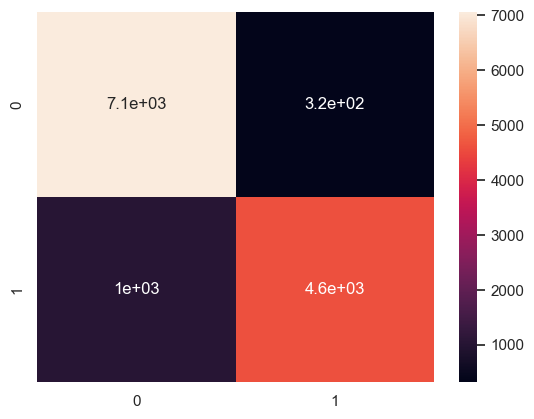

In [72]:
# metrics on the testing dataset

y_pred = best_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7378
           1       0.93      0.82      0.87      5604

    accuracy                           0.90     12982
   macro avg       0.90      0.89      0.89     12982
weighted avg       0.90      0.90      0.90     12982



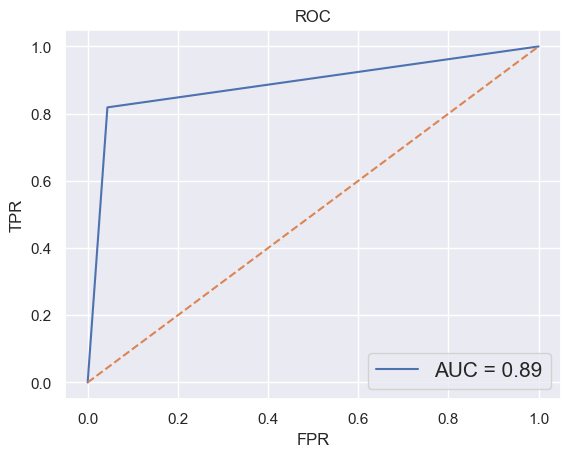

In [74]:
# ROC-AUC curve indicates the good model performance

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr,tpr, label = "AUC = %.2f" % roc_auc_score(y_test, y_pred))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc="lower right", prop={'size':15})
plt.show()

# DecissionTreeClassifier

The second chosen model is `DecissionTreeClassifier` which is also fast, easy to interpret and can be pruned to avoid overfitting. This time I have decided to optimize for *recall* to minimize the number of *false negatives*. In other words all fraud events should be detected even at the cost of classifying all suspicious event as fraud which may be harmful for normal users. Best parameters of the model are found using `RandomSearch` wich *cross-validation* because of the size of the grid to be sampled. Even better, the *Bayesian optimization* methods can be used to find even better model parameters.

## RandomSearch

In [75]:
# pameters supported by the model

model_DT = DecisionTreeClassifier()
model_DT.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [76]:
# parameters grid used for RandomSearch with cross-validation

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": np.linspace(2, 5, 5, dtype=int),
    "min_samples_split": np.linspace(5, 50, 10, dtype=int),
    "min_samples_leaf": np.linspace(5, 50, 10, dtype=int),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": np.linspace(5, 10, 10, dtype=int)
}

rs = RandomizedSearchCV(model_DT,
                        param_grid,
                        n_iter=100,
                        cv=5,
                        scoring='recall',
                        random_state=RANDOM_STATE)

rs = rs.fit(X_train, y_train)

In [77]:
# here we optimize for 'recall'

print(f"Best params: {rs.best_params_}")
print(f"Best score: {round(rs.best_score_, 3)}")

Best params: {'splitter': 'best', 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_leaf_nodes': 6, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'log_loss'}
Best score: 0.787


## Best model

In [78]:
# retraining the best found model on the entire training dataset

best_model2 = DecisionTreeClassifier(**rs.best_params_)
best_model2.fit(X_train, y_train)

print(f"Best score: {round(rs.best_score_, 3)}")

Best score: 0.787


In [79]:
# importance of different model features (note the model pruning)

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model2.feature_importances_.round(3)
})

# sort the df by importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

,Feature,Importance
0,high_fraud_clicks,0.783
1,transactions,0.091
2,clicks_fraud_3,0.087
3,clicks_device_consistency,0.026
4,empty_url_clicks,0.014
5,clicks_fraud_2,0.000
6,fraud_clicks_ratio,0.000
7,transactions_per_dist_ads,0.000
8,empty_url_clicks_fraud_3_interaction,0.000
9,transactions_rtb_interaction,0.000


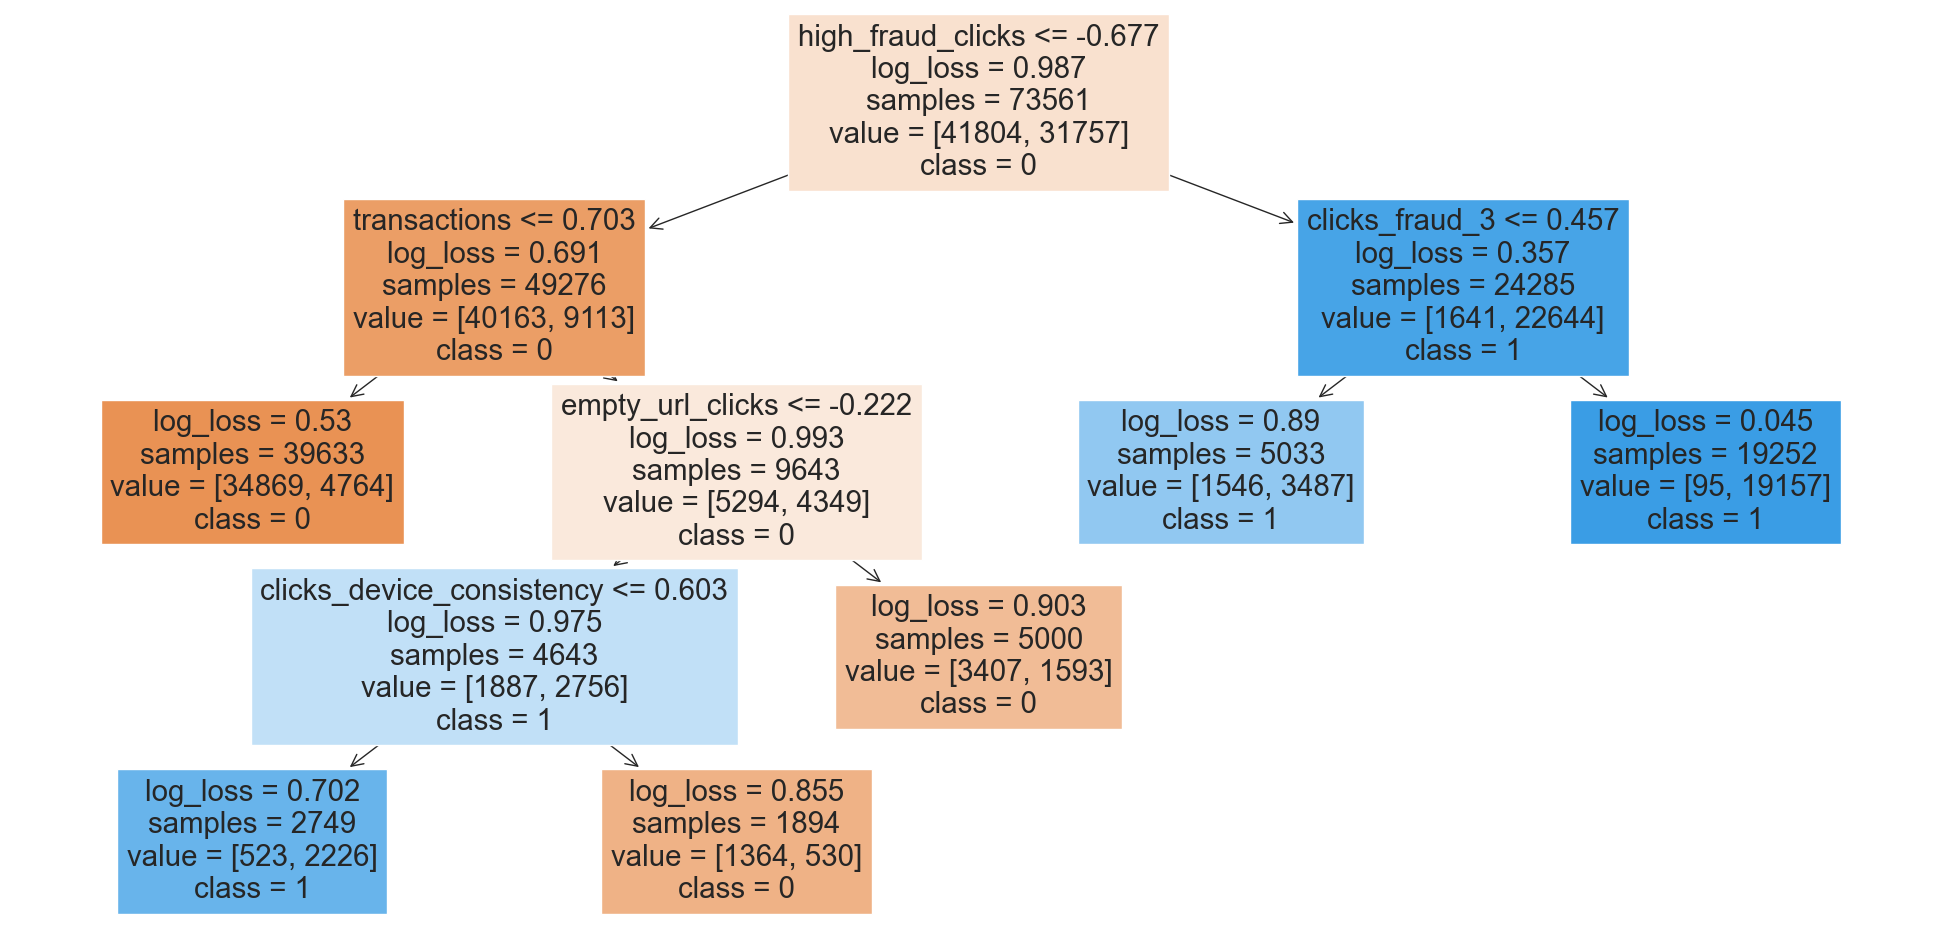

In [80]:
# plot the finally trained model (note the tree pruning)

fig = plt.figure(figsize=(25, 12))

plot_tree(
    best_model2,
    feature_names=model2.feature_names_in_.tolist(),
    class_names=best_model2.classes_.astype('str').tolist(),
    filled=True
);

## Performance metrics

We compute the confussion matrices as well as classification reports for both training and testing datasets. In both cases the results are comparable thus no overfitting occurs. All the metrics are around 90% but in case of imbalanced dataset the *accuracy* is not a good indicator (note here we maximize for *recall*). *Recall* is greater for negative (non-fraudulent) class (similar to `LogisticRegression` model) and we can also see the drop in *precision* score.

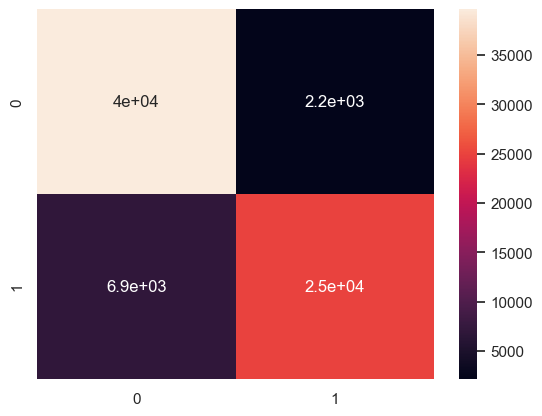

In [81]:
# metrics on the training dataset

preds = best_model2.predict(X_train)

sns.heatmap(confusion_matrix(y_train, preds), annot=True)
plt.show()

In [82]:
print(classification_report(y_train, preds))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     41804
           1       0.92      0.78      0.85     31757

    accuracy                           0.88     73561
   macro avg       0.89      0.87      0.87     73561
weighted avg       0.88      0.88      0.88     73561



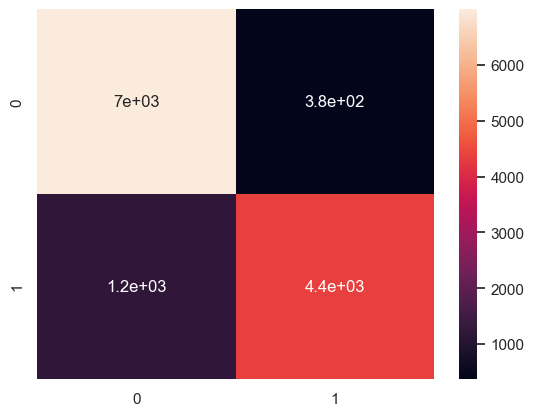

In [83]:
# metrics on the testing dataset

y_pred = best_model2.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7378
           1       0.92      0.78      0.85      5604

    accuracy                           0.88     12982
   macro avg       0.89      0.87      0.87     12982
weighted avg       0.88      0.88      0.87     12982



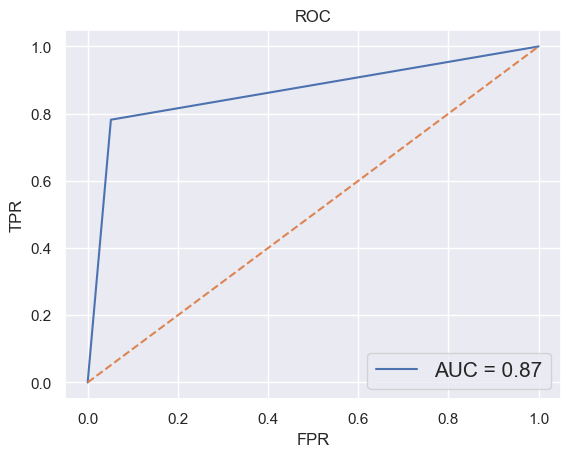

In [85]:
# ROC-AUC curve indicates the good model performance

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr,tpr, label = "AUC = %.2f" % roc_auc_score(y_test, y_pred))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc="lower right", prop={'size':15})
plt.show()

# Save the trained models

As a first basic step in good MLOps pracice I have versioned the pretrained models in the `pickle` files so they can be loaded at hand and the new dataset (previously prepared using automated feature engineering pipeline). Below are the test that loaded models produce the same results as before. Additional steps to be implemented includes: creating virtual environment with configuration files (or better: `Docker` container), saving environment variables to `TXT`, `JSON` or `CSV` files, and data versioning (preferably on `MLFlow` platform). This way the experiments can be repeated in case of potential problems.

## Dump to pickle files

In [86]:
# assume 'best_model' is your trained LR model

pickle_file = os.path.join(models_path, "best_model.pkl")

with open(pickle_file, 'wb') as file:
    pickle.dump(best_model, file)

In [87]:
# assume 'best_model2' is your trained DT model

pickle_file2 = os.path.join(models_path, "best_model2.pkl")

with open(pickle_file2, 'wb') as file:
    pickle.dump(best_model2, file)

## Loading the model

In [88]:
# load the model from the file

with open(pickle_file, 'rb') as file:
    loaded_model = pickle.load(file)

# sse the loaded model to make predictions
predictions = loaded_model.predict(X_test)

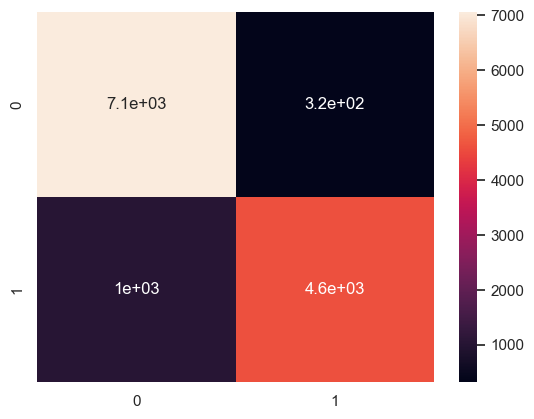

In [89]:
# check if the loaded model produce the same results for LogisticRegression

sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
plt.show()

In [90]:
# load the model from the file

with open(pickle_file2, 'rb') as file:
    loaded_model2 = pickle.load(file)

# use the loaded model to make predictions
predictions = loaded_model2.predict(X_test)

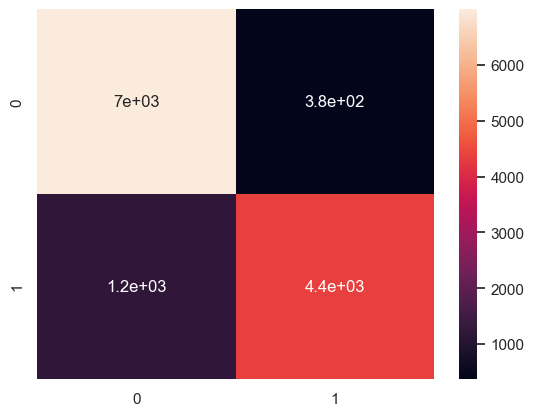

In [91]:
# check if the loaded model produce the same results for DecissionTreeClassifier

sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
plt.show()

# Bonus: features filtering

Instead of manual feature selection or using the L1-regularization to limit the number of features used for model training, we can use the automatic approach for filter best features for the model training. Here we use mutual information between each feature and class label. Another approach is to use another ML model for initial features selection (via `SelectFromModel` method or step selection using different `RFE` variants), with proper cross-validation if necessary.

In [92]:
pipeline = Pipeline([
    ("feature_filter", SelectKBest(mutual_info_classif, k=5)),
    ("model", loaded_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")

Accuracy: 0.843


In [93]:
# retrieve the selected feature names with corresponding importances

selected_features_mask = pipeline.named_steps['feature_filter'].get_support()
selected_feature_names = X_train.columns[selected_features_mask]

importances = pipeline.named_steps['model'].coef_

In [94]:
# create a dataframe sorted by feature importances

importance_df = pd.DataFrame({'Feature': selected_feature_names.tolist(),
                             'Importance': importances[0].tolist()})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

,Feature,Importance
0,clicks_fraud_4,1.789553
1,high_fraud_clicks,1.285542
2,clicks_fraud_3,0.812739
3,clicks_fraud_2,0.709672
4,fraud_clicks_ratio,-0.405778


# Discussion

I have presented several machine learning models trained on the initial dataset. When tuning the model parameters I have decided to maximize the *recall* or *F1-score* metrics to take into account the scenario we want to detect all suspicious situations even then some of them are not (here *F1-score* is a kind of compromise to take into account the *precision* metric as well). I have decided for the two fastest algorithms, named `LogisticRegression` and `DecissionTreeClassifier` which have almot 90% score on both training and testing datasets (so no overfitting is present). They are also convenient because of explainability which might be important in some business scenarios. Both are working well on this balanced dataset (however, the potential solutions is case of imbalanced are also discussed).

The `ID` column is typically dropped when preparing data for machine learning because it serves as a unique identifier for each row and does not contain information relevant to predicting the target variable (in this case, whether a user is fraudulent). Including the `ID` column in the feature set can introduce noise and may negatively impact the performance of the model. The model might inadvertently learn patterns based on the unique `IDs`, which do not generalize well to unseen data. However, if there are specific scenarios or features derived from `ID` that could be useful, one should consider those carefully. 

Having access to temporal acpects of the data, some temporal patters can be potentially found wchich might be crucial in detecting fraud. Also, it might be interesting to integrating the trained model with unsupervised anomaly detection methods (including *clustering* or *Gaussian mixture* models) to flag potential fraudulent activities that may not be captured by the supervised techniques. As mentioned through the analysis, several other approaches can be added, including dimensionality reduction or more sophisticated features engineering. It will be nice to check whether the binned or categorical variables changes the performance dramatically as they will be less nosiy. Morover, data quantization will increase the speed of computation.